In [89]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import alphalens as al
import nltk
from collections import defaultdict
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import Counter
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
TrainingDataPath=os.path.abspath('./Data/train')
TrainingTickerList=os.listdir(TrainingDataPath)
if '.DS_Store' in TrainingTickerList:
    TrainingTickerList.remove('.DS_Store')

In [91]:
TrainingTickerList

['AMZN',
 'AAPL',
 'UBER',
 'BABA',
 'TSLA',
 'FB',
 'GOOGL',
 'MSFT',
 'ABBV',
 'NFLX',
 'F',
 'AMD',
 'BA',
 'LULU',
 'JPM']

In [92]:
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')
sno = SnowballStemmer('english')
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words |= {"may", "business", "company", "could", "service", "result", "product", 
               "operation", "include", "law", "tax", "change", "financial", "require",
               "cost", "market", "also", "user", "plan", "actual", "cash", "other",
               "thereto", "thereof", "therefore", "bloomberg","email","photograph",
               "bloombergquint","productsbloomberg","loginbloomberg", "bloombergconnect",
               "customersbloomberg","inclusioninnovationphilanthropysustainabilitybloomberg","londonbloomberg",
               "distributionbloomberg","lawbloomberg","taxbloomberg","governmentbloomberg","environmentbloombergnef",
               "mediabloomberg","marketsbloomberg","technologybloomberg","pursuitsbloomberg","politicsbloomberg",
               "opinionbloomberg","businessweekbloomberg","conferencesbloomberg", "appsbloomberg",
               "radiobloomberg","servicesbloomberg","onbloomberg","clipsbloomberg","saysbloomberg","bloombergolaf",
               "bloombergwhat","loginsoftwar",'followfacebooktwitterlinkedininstagram',
               'facebooktwitterinstagramlinkedin','twitterfacebook'}

In [93]:
def clean_text(txt):
    #txt: text body string
    #return: cleaned tockens list
    lemm_txt = [ wnl.lemmatize(wnl.lemmatize(w.lower(),'n'),'v') \
                for w in word_tokenizer.tokenize(txt)[1:] if \
                w.isalpha() and "bloomberg" not in w and w not in stop_words \
                and wnl.lemmatize(wnl.lemmatize(w.lower(),'n'),'v') not in stop_words]
    return [ sno.stem(w) for w in lemm_txt if w not in stop_words and len(w) > 2 and "bloomberg" not in w and sno.stem(w) not in stop_words]

In [94]:
def bag_of_words(words):
    # words: cleaned tokens list
    dictWords = defaultdict(int)
    for word in words:
        dictWords[word] +=1
    return dictWords

In [95]:
def struct_article_data(datapath,tickerlist):
    articles=[]
    for ticker in tickerlist:
        folder=os.path.join(datapath,ticker) # folder path
        docname=os.listdir(folder)
        if '.DS_Store' in docname:
            docname.remove('.DS_Store')
        
        for doc in docname: # eg: doc='20190115_+0.036786_0.txt'
            with open(os.path.join(folder,doc)) as f:
                if doc[9:18][-1] == '_':
                    NextDayReturn = np.float(0)
                else:
                    NextDayReturn = np.float(doc[9:18])
                
                articles.append({'BOW':bag_of_words(clean_text(''.join(f))),
                                 'Ticker':ticker,
                                 'ReleaseDate':doc[:4]+'-'+doc[4:6]+'-'+doc[6:8],
                                 'NextDayReturn':NextDayReturn})
    
    return articles

In [96]:
articles_training=struct_article_data(TrainingDataPath,TrainingTickerList)

In [97]:
articles_training[0]

{'BOW': defaultdict(int,
             {'aapl': 1,
              'alphabet': 2,
              'amazon': 1,
              'amzn': 1,
              'anoth': 1,
              'appl': 1,
              'applic': 1,
              'april': 1,
              'asset': 2,
              'assist': 1,
              'august': 1,
              'autom': 1,
              'averag': 1,
              'berkshir': 1,
              'biggest': 2,
              'billion': 14,
              'boost': 1,
              'brexit': 1,
              'brk': 1,
              'chairman': 1,
              'chase': 1,
              'click': 2,
              'com': 1,
              'comment': 1,
              'commit': 1,
              'compil': 1,
              'corp': 2,
              'cut': 1,
              'dashboard': 1,
              'data': 2,
              'day': 2,
              'earli': 1,
              'equiti': 12,
              'etf': 6,
              'europ': 1,
              'excel': 1,
              'exchang':

In [98]:
articles_training[20]

{'BOW': defaultdict(int,
             {'add': 1,
              'advanc': 1,
              'ahead': 1,
              'almost': 1,
              'amazon': 2,
              'among': 1,
              'appl': 4,
              'back': 1,
              'best': 1,
              'better': 1,
              'biggest': 1,
              'bode': 1,
              'broadcom': 1,
              'china': 1,
              'com': 1,
              'corp': 1,
              'devic': 1,
              'disappoint': 1,
              'dozen': 1,
              'earlier': 1,
              'earn': 2,
              'ecosystem': 1,
              'eric': 2,
              'exchang': 1,
              'extend': 1,
              'facebook': 2,
              'fear': 1,
              'forecast': 2,
              'fund': 1,
              'gainer': 1,
              'get': 1,
              'getti': 2,
              'heavyweight': 1,
              'imag': 2,
              'inc': 6,
              'index': 2,
              'invest

In [99]:
len(articles_training)

12977

In [100]:
def sgn(v):
    if v>0:
        return 1;
    if v<0:
        return 0;
    if v==0:
        return 0.5;

In [101]:
def get_sentiment_charged_words(articles, alpha_pos, alpha_neg, kappa, stop_words):
    occurance=defaultdict(int)
    pos_occr=defaultdict(int)
    neg_occr=defaultdict(int)
    for article in articles:
        if sgn(article['NextDayReturn'])==1:
            flag=(1,0)
        elif sgn(article['NextDayReturn'])==0:
            flag=(0,1)
        else:
            flag=(0,0)
        
        for key, value in article['BOW'].items():
            if value>0 and key not in stop_words:
                occurance[key] += 1
                pos_occr[key] += flag[0]
                neg_occr[key] += flag[1]
    
    sentiment_charged_words=[]
    pos_words=[]
    neg_words=[]
    for word, count in occurance.items():
        if (count>kappa) and (pos_occr[word]/count > (0.5+alpha_pos)):
            pos_words.append(word)
            sentiment_charged_words.append(word)
        if (count>kappa) and (neg_occr[word]/count > (0.5+alpha_neg)):
            neg_words.append(word)
            sentiment_charged_words.append(word)
        
    return [pos_words,neg_words,sentiment_charged_words,occurance,pos_occr,neg_occr]

In [102]:
def get_document_matrix(articles, sentiment_charged_words):
    DocMatrix=np.zeros((len(articles),len(sentiment_charged_words)))
    for i in range(len(articles)):
        DocVector=[articles[i]['BOW'][word] for word in sentiment_charged_words]
        if np.sum(DocVector) != 0:
            DocMatrix[i]=DocVector/np.sum(DocVector)
        else:
            DocMatrix[i]=DocVector
    
    return DocMatrix

In [103]:
def get_training_sentiment_score(articles):
    SentimentScoreMatrix=np.zeros((2,len(articles)))
    SentimentScoreMatrix[0]=pd.Series([ article['NextDayReturn'] for article in articles ]).rank().values/len(articles)
    SentimentScoreMatrix[1]=1-SentimentScoreMatrix[0]
    
    return SentimentScoreMatrix

In [104]:
def get_estimated_words_distribution(DocMatrix, SSMatrix):
    #SSMatrix: SentimentScoreMatrix
    WordsDistribution=DocMatrix.T.dot(SSMatrix.T).dot(np.linalg.pinv(SSMatrix.dot(SSMatrix.T)))
    WordsDistribution=np.where(WordsDistribution<0,0,WordsDistribution)
    WordsDistribution=WordsDistribution/WordsDistribution.sum(axis=0)
    
    return WordsDistribution

In [105]:
def get_training_result(articles_training,alpha_pos,alpha_neg,kappa,stop_words):
    # get_sentiment_charged_words(articles, alpha_pos, alpha_neg, kappa):
    [pos_words,neg_words,sentiment_charged_words,occurance,pos_occr,neg_occr]=\
                               get_sentiment_charged_words(articles_training, alpha_pos, alpha_neg, kappa,stop_words)

    # get_document_matrix(articles, sentiment_charged_words):
    DocMatrix=get_document_matrix(articles_training, sentiment_charged_words)

    # get_training_sentiment_score(articles):
    SentimentScoreMatrix=get_training_sentiment_score(articles_training)

    # get_estimated_words_distribution(DocMatrix, SSMatrix):
    WordsDistribution=get_estimated_words_distribution(DocMatrix, SentimentScoreMatrix)
    
    return [pos_words,neg_words,sentiment_charged_words,occurance,pos_occr,neg_occr,WordsDistribution]

In [106]:
def get_sentiment_score_prediction(bow, SCWords, WordsDist, lamb, InitGuess):
    #bow: BoW of the new article
    #SCWords: sentiment-charged words list
    #WordsDist: trained words distribution (of sentiment-charged words), 2darray
    #lamb: coefficient of penalty, i.e learning rate
    #InitGuess: initial guess of sentiment score
    DocVector=[ bow[word] for word in SCWords ]
    if np.sum(DocVector) != 0:
        DocVector=DocVector/np.sum(DocVector)
    else:
        DocVector=np.array(DocVector)
    
    def neg_penalized_likelihood(SentimentScore):
        q = SentimentScore*WordsDist.T[0] + (1-SentimentScore)*WordsDist.T[1]
        val=np.sum([ DocVector[i]*np.log(q[i]) for i in range(DocVector.shape[0]) ]) \
                  + lamb*np.log(SentimentScore*(1-SentimentScore))
        return -val
    
    result=sp.optimize.minimize(neg_penalized_likelihood,InitGuess,method='SLSQP',bounds=[(0,1)])
    
    return result.x[0]

#### Now grid search for appopriate threshold  ( $\alpha_+$, $\alpha_-$, $\kappa$, $\lambda$ )
#### Analysis is based on single factor analysis, mainly focusing on IC / IR ( ?? )

In [107]:
def get_sentiment_score_prediction_table(sentiment_charged_words,WordsDistribution,articles_validation,lamb):
    
    ###  Now we have word distribution from articles_training ###
    ###  Tend to get sentiment score prediction of every article in articles_validation ###
    
    ArticlePrediction={} # save prediction of article which is in articles_validation, form is like:
    
    #   {'AAPL': {'2019-01-16': DefaultDict_float{'PredictionScore':2.35252,
    #                                             'count': 3
    #                                            }
    #             '2019-01-17': DefaultDict_float{'PredictionScore':6.25253,
    #                                             'count': 6
    #                                            }
    #            }
    #
    #    'MSFT': {'2019-01-16': DefaultDict_float{'PredictionScore':2.35252,
    #                                             'count': 3
    #                                            }
    #             '2019-01-17': DefaultDict_float{'PredictionScore':6.25253,
    #                                             'count': 6
    #                                            }
    #            }
    #
    #    }
    
    TrackingNum=0
    print('Prediction work start. Total workload will be: ',len(articles_validation))
    
    for article in articles_validation:
        # get_sentiment_score_prediction(bow, SCWords, WordsDist, lamb, InitGuess):
        PredictedScore=get_sentiment_score_prediction(article['BOW'],sentiment_charged_words,WordsDistribution,lamb,0.5)
        
        TrackingNum += 1
        print('Prediction for a new article done: ',article['Ticker'],', ',article['ReleaseDate'],', TrackingNum: ',TrackingNum)
        
        if article['Ticker'] not in ArticlePrediction.keys():
            ArticlePrediction[article['Ticker']]={}
        
        if article['ReleaseDate'] not in ArticlePrediction[article['Ticker']].keys():
            ArticlePrediction[article['Ticker']][article['ReleaseDate']]=defaultdict(float)
        
        ArticlePrediction[article['Ticker']][article['ReleaseDate']]['Prediction'] += PredictedScore
        ArticlePrediction[article['Ticker']][article['ReleaseDate']]['count'] += 1
    
    
    print('Prediction all complete')
    
    date=set()
    for score in ArticlePrediction.values():
        date |= set(score.keys())
    
    
    print('Start creating table')
    
    table=pd.DataFrame(columns=ArticlePrediction.keys(), index=date)
    for ticker in ArticlePrediction.keys():
        for date_ in date:
            if date_ in ArticlePrediction[ticker].keys():
                PredictionScore=ArticlePrediction[ticker][date_]['Prediction']
                count=ArticlePrediction[ticker][date_]['count']
                table.loc[date_,ticker]=PredictionScore/count
            else:
                table.loc[date_,ticker]=np.nan
    
    print('Create table complete')
    
    table.index=pd.to_datetime(table.index,format='%Y-%m-%d')
    table=table.sort_index(axis=0,ascending=True)
    
    return table


In [108]:
TestDataPath=os.path.abspath('./Data/test')
TestTickerList=os.listdir(TestDataPath)
if '.DS_Store' in TestTickerList:
    TestTickerList.remove('.DS_Store')

In [109]:
TestTickerList

['AMZN',
 'AAPL',
 'UBER',
 'BABA',
 'TSLA',
 'FB',
 'GOOGL',
 'MSFT',
 'NFLX',
 'F',
 'AMD',
 'BA',
 'DIS',
 'LULU',
 'JPM']

In [110]:
articles_test=struct_article_data(TestDataPath,TestTickerList)

In [111]:
articles_test[0]

{'BOW': defaultdict(int,
             {'abercrombi': 3,
              'absorb': 1,
              'accessori': 1,
              'accord': 3,
              'across': 1,
              'addit': 2,
              'adler': 2,
              'adob': 1,
              'advisori': 1,
              'aeri': 3,
              'ahead': 2,
              'airpod': 1,
              'amazon': 2,
              'american': 4,
              'amzn': 1,
              'analyst': 7,
              'analyt': 1,
              'anderson': 1,
              'anoth': 2,
              'anthropologi': 1,
              'apparel': 5,
              'appear': 3,
              'appl': 2,
              'applianc': 1,
              'area': 2,
              'athlet': 1,
              'athletica': 1,
              'bag': 3,
              'balanc': 1,
              'bank': 1,
              'banner': 1,
              'bannertraff': 1,
              'base': 3,
              'bath': 5,
              'beauti': 1,
              'bed': 1

In [112]:
len(articles_test)

5040

In [127]:
[pos_words,neg_words,sentiment_charged_words,occurance,pos_occr,neg_occr,WordsDistribution]=\
                                                       get_training_result(articles_training,0.13,0.2,20,stop_words)

(-0.5, 4999.5, 2999.5, -0.5)

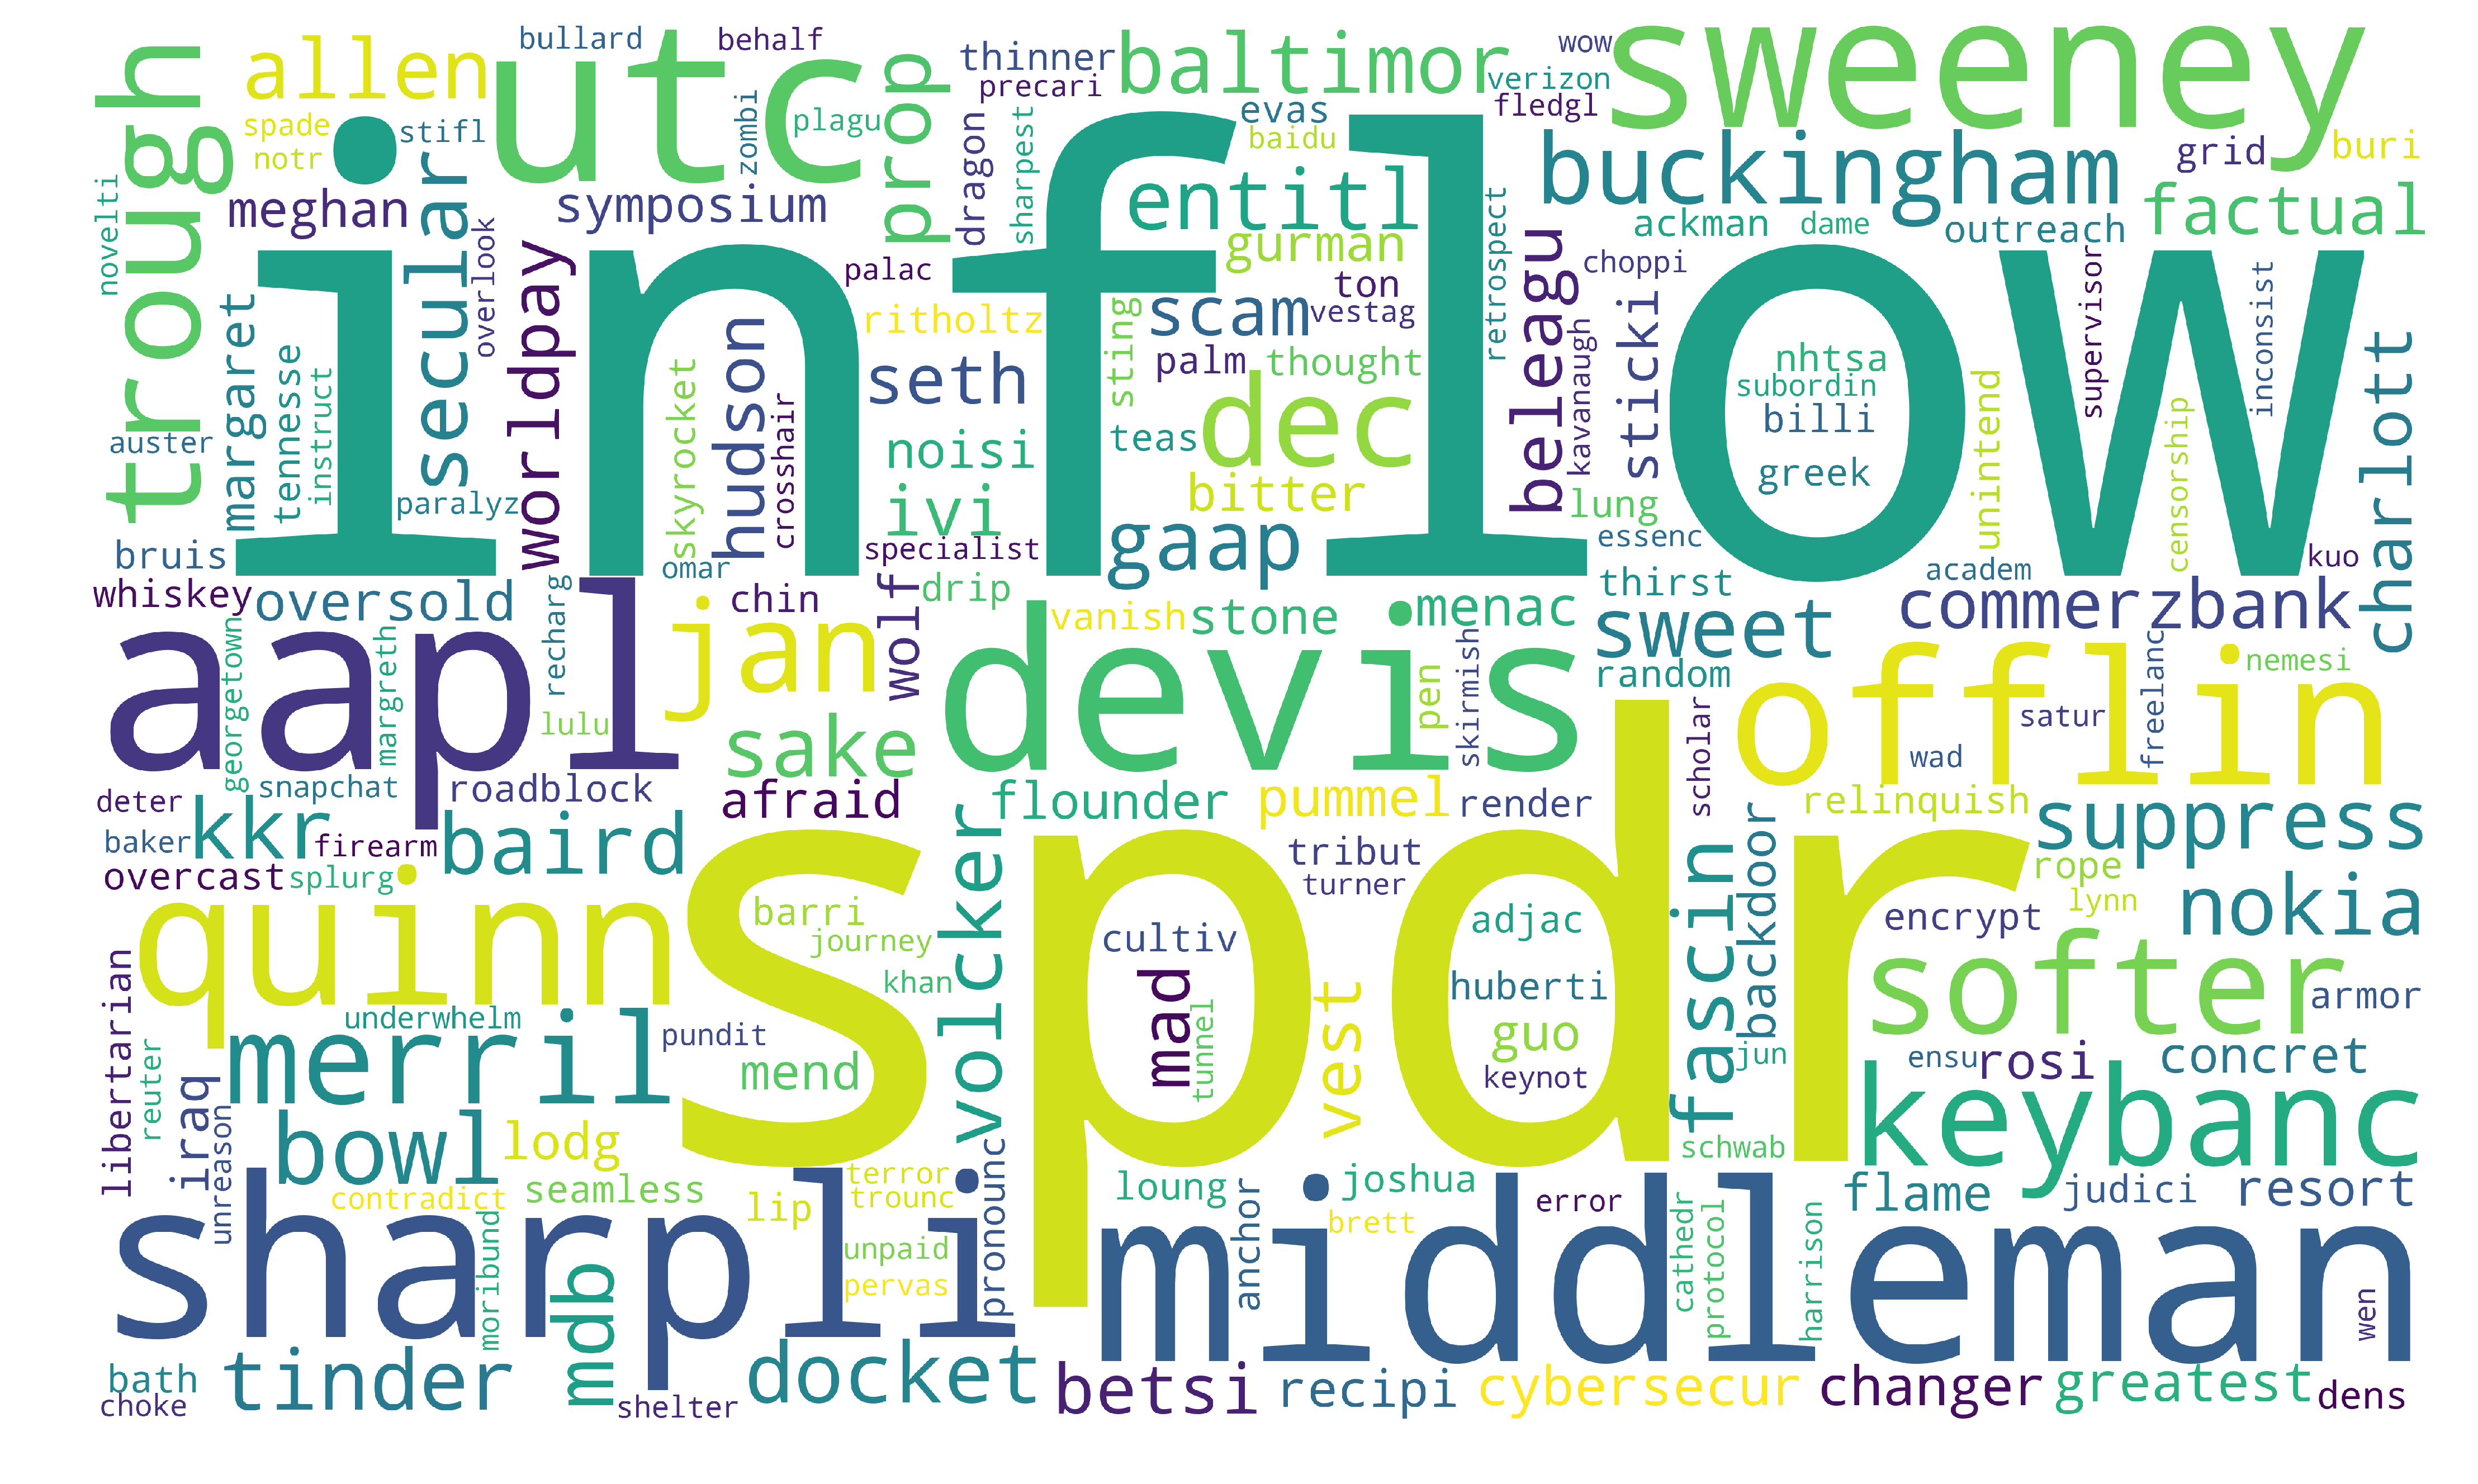

In [128]:
plt.figure(figsize=(18,12),dpi=300)
PosWordCloud = WordCloud(background_color="white",width=5000, height=3000, margin=2).generate(' '.join(pos_words))
plt.imshow(PosWordCloud)
plt.axis('off')

(-0.5, 4999.5, 2999.5, -0.5)

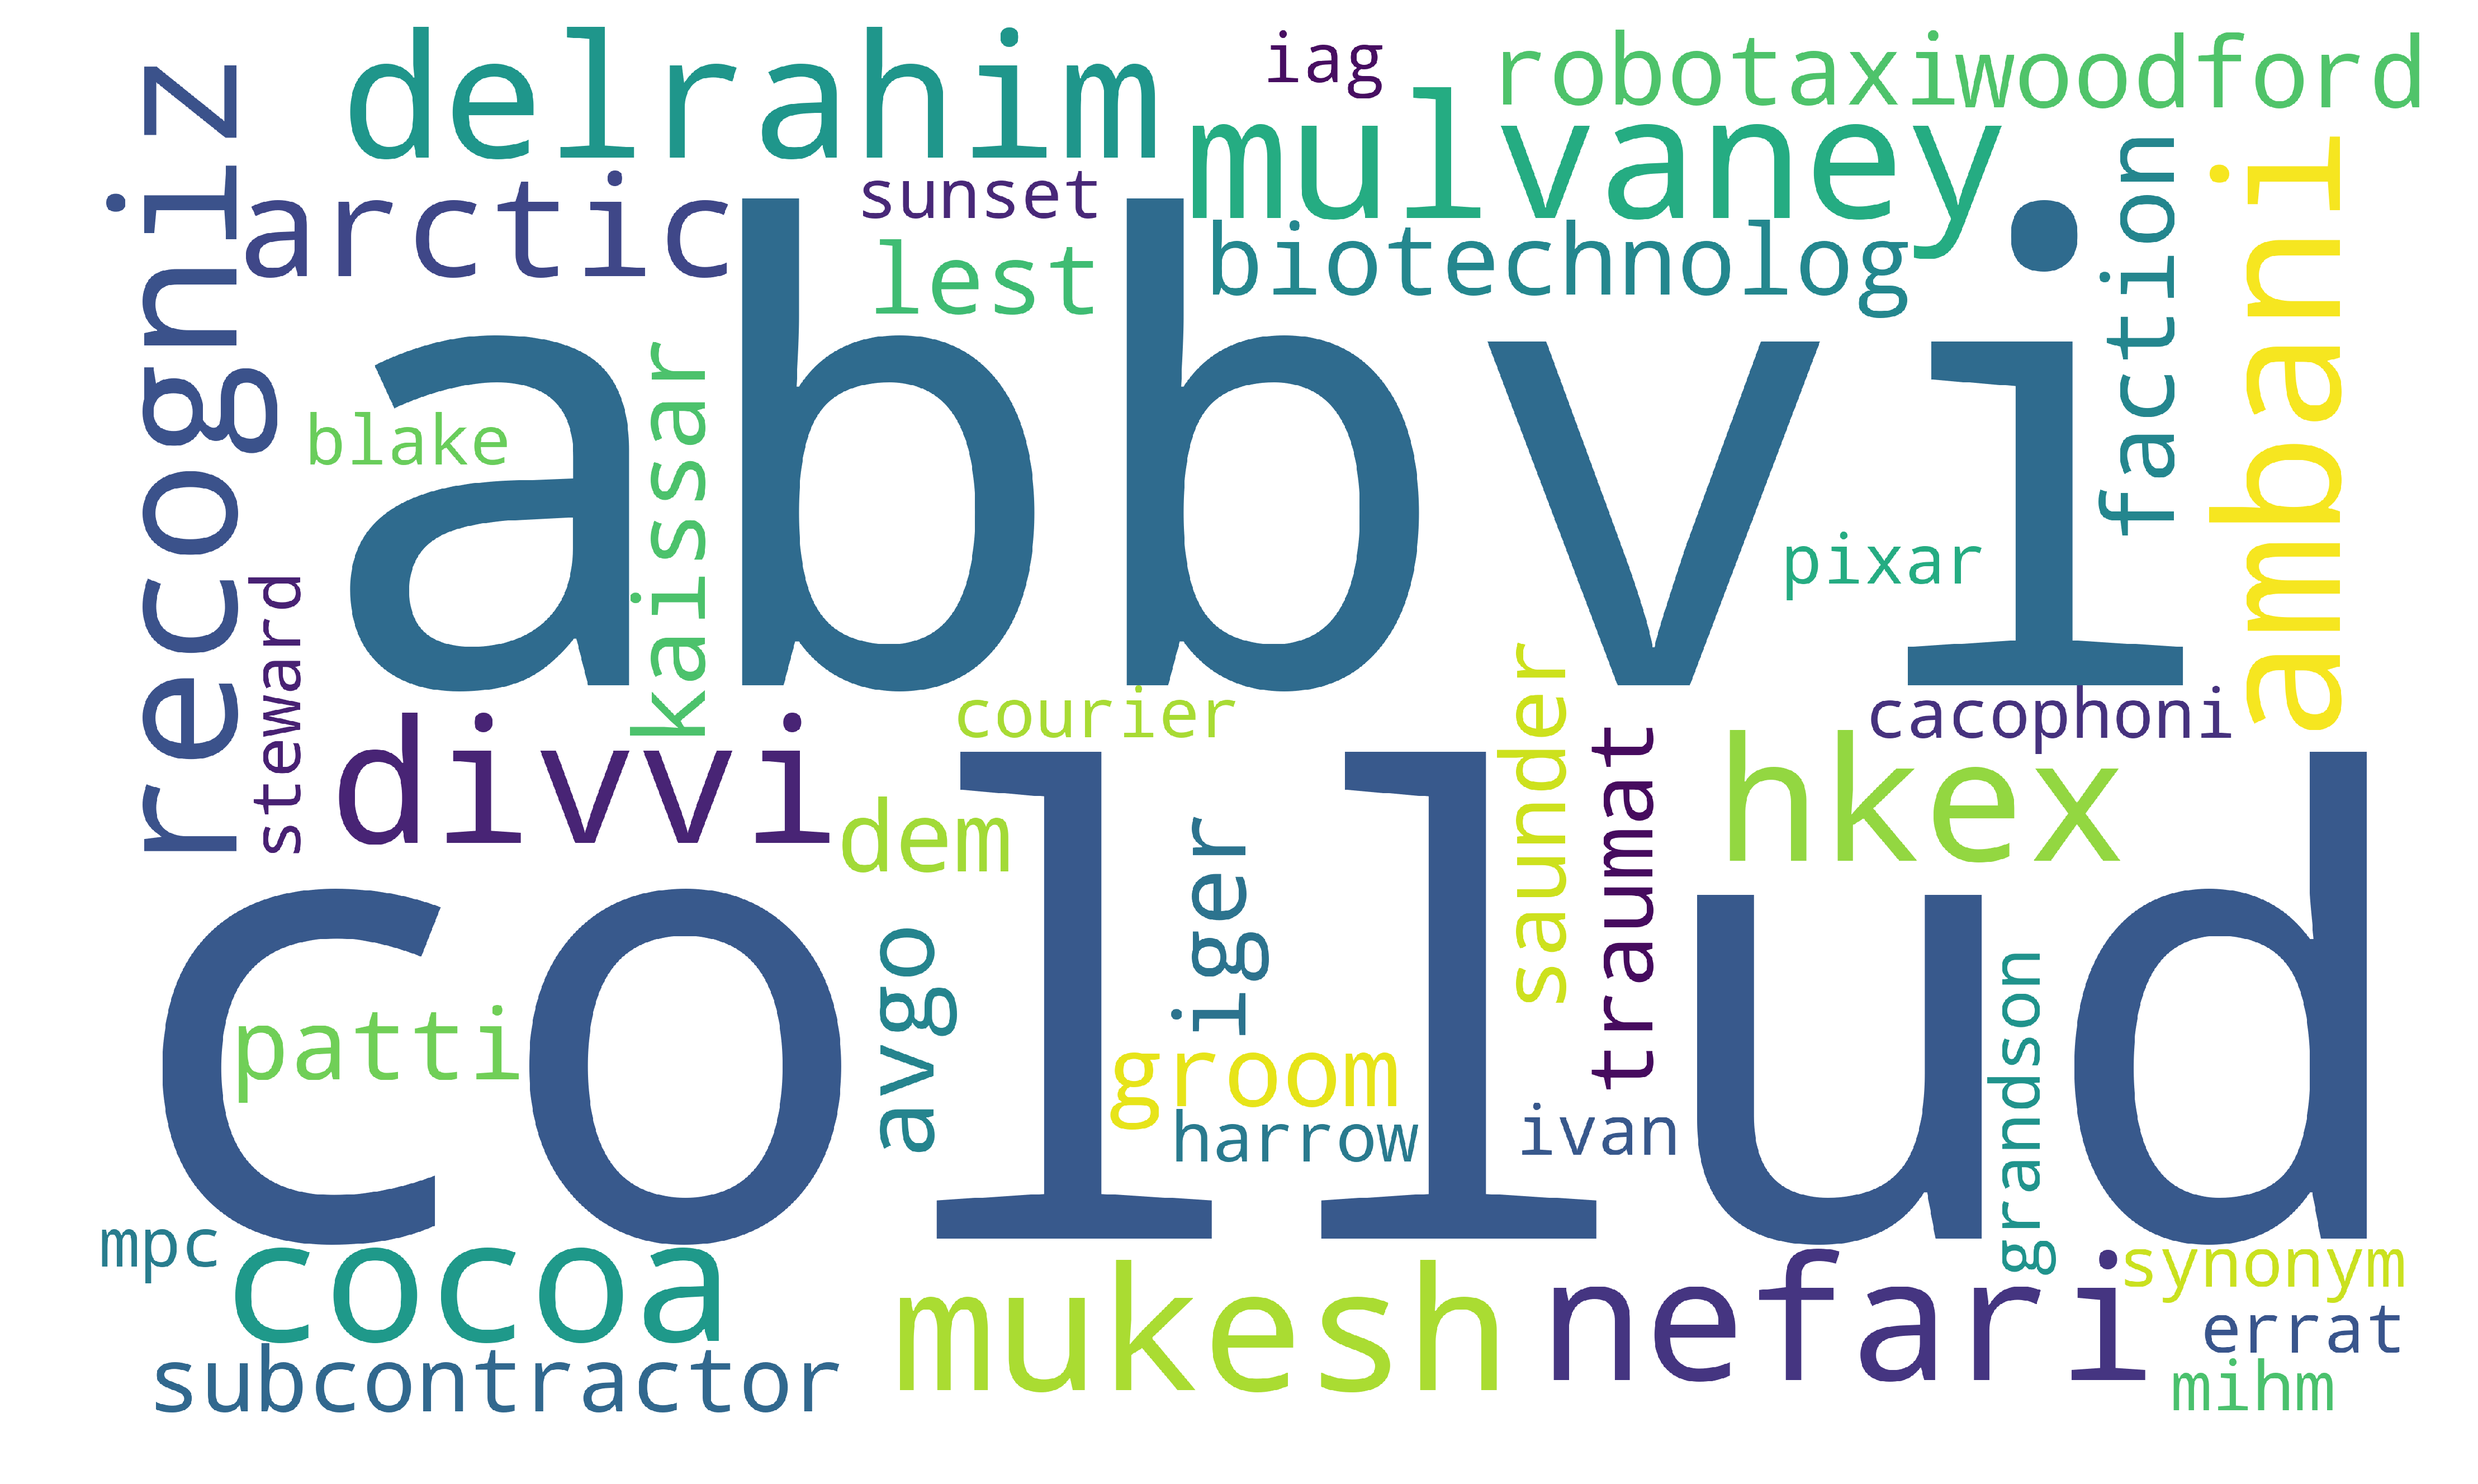

In [129]:
plt.figure(figsize=(18,12),dpi=300)
NegWordCloud = WordCloud(background_color="white",width=5000, height=3000, margin=2).generate(' '.join(neg_words))
plt.imshow(NegWordCloud)
plt.axis('off')

In [130]:
sentiment_charged_words

['spdr',
 'inflow',
 'aapl',
 'middleman',
 'sharpli',
 'devis',
 'utc',
 'sweeney',
 'offlin',
 'quinn',
 'keybanc',
 'softer',
 'trough',
 'merril',
 'jan',
 'dec',
 'abbvi',
 'buckingham',
 'bowl',
 'suppress',
 'docket',
 'sweet',
 'kkr',
 'prop',
 'tinder',
 'baltimor',
 'entitl',
 'baird',
 'allen',
 'gaap',
 'sake',
 'mdb',
 'fascin',
 'secular',
 'nokia',
 'volcker',
 'commerzbank',
 'betsi',
 'seth',
 'charlott',
 'worldpay',
 'beleagu',
 'mad',
 'scam',
 'ivi',
 'factual',
 'vest',
 'hudson',
 'cybersecur',
 'greatest',
 'sticki',
 'pummel',
 'menac',
 'collud',
 'oversold',
 'changer',
 'wolf',
 'symposium',
 'rosi',
 'stone',
 'mend',
 'resort',
 'flounder',
 'noisi',
 'concret',
 'bitter',
 'lodg',
 'gurman',
 'mulvaney',
 'nefari',
 'flame',
 'margaret',
 'iraq',
 'backdoor',
 'guo',
 'recipi',
 'afraid',
 'meghan',
 'relinquish',
 'ackman',
 'billi',
 'libertarian',
 'drip',
 'sting',
 'seamless',
 'thinner',
 'thought',
 'anchor',
 'overcast',
 'barri',
 'ritholtz',
 'r

In [131]:
len(sentiment_charged_words)

787

In [132]:
occurance

defaultdict(int,
            {'trader': 973,
             'stock': 3676,
             'via': 904,
             'world': 5328,
             'biggest': 3374,
             'exchang': 1345,
             'trade': 5369,
             'fund': 2877,
             'equiti': 1932,
             'ralli': 1297,
             'stall': 286,
             'billion': 5030,
             'flow': 847,
             'state': 2277,
             'street': 1879,
             'corp': 2583,
             'spdr': 38,
             'etf': 732,
             'trust': 723,
             'monday': 1726,
             'sinc': 4445,
             'april': 1399,
             'data': 3867,
             'compil': 852,
             'show': 3891,
             'boost': 1672,
             'asset': 2262,
             'highest': 913,
             'month': 5234,
             'start': 3852,
             'day': 4089,
             'averag': 1537,
             'first': 4824,
             'time': 5994,
             'earli': 2036,
             

In [133]:
pos_occr

defaultdict(int,
            {'trader': 533,
             'stock': 1972,
             'via': 476,
             'world': 2880,
             'biggest': 1796,
             'exchang': 721,
             'trade': 2897,
             'fund': 1591,
             'equiti': 1044,
             'ralli': 729,
             'stall': 155,
             'billion': 2644,
             'flow': 458,
             'state': 1249,
             'street': 1049,
             'corp': 1366,
             'spdr': 26,
             'etf': 428,
             'trust': 418,
             'monday': 899,
             'sinc': 2368,
             'april': 744,
             'data': 2129,
             'compil': 456,
             'show': 2082,
             'boost': 916,
             'asset': 1252,
             'highest': 510,
             'month': 2797,
             'start': 2096,
             'day': 2147,
             'averag': 845,
             'first': 2598,
             'time': 3188,
             'earli': 1060,
             'augus

In [134]:
pos_words

['spdr',
 'inflow',
 'aapl',
 'middleman',
 'sharpli',
 'devis',
 'utc',
 'sweeney',
 'offlin',
 'quinn',
 'keybanc',
 'softer',
 'trough',
 'merril',
 'jan',
 'dec',
 'buckingham',
 'bowl',
 'suppress',
 'docket',
 'sweet',
 'kkr',
 'prop',
 'tinder',
 'baltimor',
 'entitl',
 'baird',
 'allen',
 'gaap',
 'sake',
 'mdb',
 'fascin',
 'secular',
 'nokia',
 'volcker',
 'commerzbank',
 'betsi',
 'seth',
 'charlott',
 'worldpay',
 'beleagu',
 'mad',
 'scam',
 'ivi',
 'factual',
 'vest',
 'hudson',
 'cybersecur',
 'greatest',
 'sticki',
 'pummel',
 'menac',
 'oversold',
 'changer',
 'wolf',
 'symposium',
 'rosi',
 'stone',
 'mend',
 'resort',
 'flounder',
 'noisi',
 'concret',
 'bitter',
 'lodg',
 'gurman',
 'flame',
 'margaret',
 'iraq',
 'backdoor',
 'guo',
 'recipi',
 'afraid',
 'meghan',
 'relinquish',
 'ackman',
 'billi',
 'libertarian',
 'drip',
 'sting',
 'seamless',
 'thinner',
 'thought',
 'anchor',
 'overcast',
 'barri',
 'ritholtz',
 'random',
 'evas',
 'unintend',
 'nhtsa',
 'jos

In [135]:
len(pos_words)

747

In [136]:
len(neg_words)

40

In [137]:
WordsDistribution

array([[ 0.00252066,  0.00137415],
       [ 0.00778425,  0.00829764],
       [ 0.00078944,  0.00085269],
       ..., 
       [ 0.00079373,  0.00061462],
       [ 0.00025901,  0.00370766],
       [ 0.00227058,  0.00121079]])

In [138]:
np.any(np.isnan(WordsDistribution))

False

In [139]:
SentimentTableTrain=get_sentiment_score_prediction_table(sentiment_charged_words,WordsDistribution,articles_training,0.1)

Prediction work start. Total workload will be:  12977
Prediction for a new article done:  AMZN ,  2019-09-10 , TrackingNum:  1
Prediction for a new article done:  AMZN ,  2019-01-31 , TrackingNum:  2
Prediction for a new article done:  AMZN ,  2019-02-20 , TrackingNum:  3
Prediction for a new article done:  AMZN , 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


 2019-04-29 , TrackingNum:  4
Prediction for a new article done:  AMZN ,  2019-09-11 , TrackingNum:  5
Prediction for a new article done:  AMZN ,  2019-02-13 , TrackingNum:  6
Prediction for a new article done:  AMZN ,  2019-08-13 , TrackingNum:  7
Prediction for a new article done:  AMZN ,  2019-04-15 , TrackingNum:  8
Prediction for a new article done:  AMZN ,  2019-02-04 , TrackingNum:  9
Prediction for a new article done:  AMZN ,  2019-05-30 , TrackingNum:  10
Prediction for a new article done:  AMZN ,  2019-04-25 , TrackingNum:  11
Prediction for a new article done:  AMZN ,  2019-04-25 , TrackingNum:  12
Prediction for a new article done:  AMZN ,  2019-06-19 , TrackingNum:  13
Prediction for a new article done:  AMZN ,  2019-03-18 , TrackingNum:  14
Prediction for a new article done:  AMZN ,  2019-07-25 , TrackingNum:  15
Prediction for a new article done:  AMZN ,  2019-01-31 , TrackingNum:  16
Prediction for a new article done:  AMZN ,  2019-02-11 , TrackingNum:  17
Prediction fo

Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  188
Prediction for a new article done:  AAPL ,  2019-03-25 , TrackingNum:  189
Prediction for a new article done:  AAPL ,  2019-09-19 , TrackingNum:  190
Prediction for a new article done:  AAPL ,  2019-05-09 , TrackingNum:  191
Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  192
Prediction for a new article done:  AAPL ,  2019-05-07 , TrackingNum:  193
Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  194
Prediction for a new article done:  AAPL ,  2019-03-25 , TrackingNum:  195
Prediction for a new article done:  AAPL ,  2019-07-04 , TrackingNum:  196
Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  197
Prediction for a new article done:  AAPL ,  2019-09-19 , TrackingNum:  198
Prediction for a new article done:  AAPL ,  2019-06-12 , TrackingNum:  199
Prediction for a new article done:  AAPL ,  2019-06-13 , TrackingNum:  200
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2019-09-22 , TrackingNum:  344
Prediction for a new article done:  AAPL ,  2019-03-13 , TrackingNum:  345
Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  346
Prediction for a new article done:  AAPL ,  2019-09-19 , TrackingNum:  347
Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  348
Prediction for a new article done:  AAPL ,  2019-03-25 , TrackingNum:  349
Prediction for a new article done:  AAPL ,  2019-01-29 , TrackingNum:  350
Prediction for a new article done:  AAPL ,  2019-02-07 , TrackingNum:  351
Prediction for a new article done:  AAPL ,  2019-04-30 , TrackingNum:  352
Prediction for a new article done:  AAPL ,  2019-06-03 , TrackingNum:  353
Prediction for a new article done:  AAPL ,  2019-05-22 , TrackingNum:  354
Prediction for a new article done:  AAPL ,  2019-05-22 , TrackingNum:  355
Prediction for a new article done:  AAPL ,  2019-06-03 , TrackingNum:  356
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2019-04-14 , TrackingNum:  593
Prediction for a new article done:  AAPL ,  2019-03-26 , TrackingNum:  594
Prediction for a new article done:  AAPL ,  2019-03-26 , TrackingNum:  595
Prediction for a new article done:  AAPL ,  2019-09-30 , TrackingNum:  596
Prediction for a new article done:  AAPL ,  2019-08-08 , TrackingNum:  597
Prediction for a new article done:  AAPL ,  2019-02-21 , TrackingNum:  598
Prediction for a new article done:  AAPL ,  2019-01-30 , TrackingNum:  599
Prediction for a new article done:  AAPL ,  2019-09-10 , TrackingNum:  600
Prediction for a new article done:  AAPL ,  2019-05-30 , TrackingNum:  601
Prediction for a new article done:  AAPL ,  2019-03-13 , TrackingNum:  602
Prediction for a new article done:  AAPL ,  2019-04-09 , TrackingNum:  603
Prediction for a new article done:  AAPL ,  2019-02-05 , TrackingNum:  604
Prediction for a new article done:  AAPL ,  2019-07-09 , TrackingNum:  605
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2019-04-08 , TrackingNum:  845
Prediction for a new article done:  AAPL ,  2019-07-31 , TrackingNum:  846
Prediction for a new article done:  AAPL ,  2019-05-15 , TrackingNum:  847
Prediction for a new article done:  AAPL ,  2019-07-29 , TrackingNum:  848
Prediction for a new article done:  AAPL ,  2019-07-17 , TrackingNum:  849
Prediction for a new article done:  AAPL ,  2019-04-15 , TrackingNum:  850
Prediction for a new article done:  AAPL ,  2019-07-31 , TrackingNum:  851
Prediction for a new article done:  AAPL ,  2019-08-12 , TrackingNum:  852
Prediction for a new article done:  AAPL ,  2019-07-18 , TrackingNum:  853
Prediction for a new article done:  AAPL ,  2019-07-29 , TrackingNum:  854
Prediction for a new article done:  AAPL ,  2019-02-13 , TrackingNum:  855
Prediction for a new article done:  AAPL ,  2019-04-15 , TrackingNum:  856
Prediction for a new article done:  AAPL ,  2019-06-23 , TrackingNum:  857
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2019-07-02 , TrackingNum:  1093
Prediction for a new article done:  AAPL ,  2019-07-22 , TrackingNum:  1094
Prediction for a new article done:  AAPL ,  2019-05-13 , TrackingNum:  1095
Prediction for a new article done:  AAPL ,  2019-05-20 , TrackingNum:  1096
Prediction for a new article done:  AAPL ,  2019-08-20 , TrackingNum:  1097
Prediction for a new article done:  AAPL ,  2019-02-20 , TrackingNum:  1098
Prediction for a new article done:  AAPL ,  2019-04-11 , TrackingNum:  1099
Prediction for a new article done:  AAPL ,  2019-08-19 , TrackingNum:  1100
Prediction for a new article done:  AAPL ,  2019-04-11 , TrackingNum:  1101
Prediction for a new article done:  AAPL ,  2019-01-15 , TrackingNum:  1102
Prediction for a new article done:  AAPL ,  2019-01-27 , TrackingNum:  1103
Prediction for a new article done:  AAPL ,  2019-04-10 , TrackingNum:  1104
Prediction for a new article done:  AAPL ,  2019-04-10 , TrackingNum:  1105
Prediction f

Prediction for a new article done:  AAPL ,  2019-01-21 , TrackingNum:  1344
Prediction for a new article done:  AAPL ,  2019-04-02 , TrackingNum:  1345
Prediction for a new article done:  AAPL ,  2019-01-23 , TrackingNum:  1346
Prediction for a new article done:  AAPL ,  2019-03-17 , TrackingNum:  1347
Prediction for a new article done:  AAPL ,  2019-04-02 , TrackingNum:  1348
Prediction for a new article done:  AAPL ,  2019-01-23 , TrackingNum:  1349
Prediction for a new article done:  AAPL ,  2019-09-11 , TrackingNum:  1350
Prediction for a new article done:  AAPL ,  2019-01-22 , TrackingNum:  1351
Prediction for a new article done:  AAPL ,  2019-01-17 , TrackingNum:  1352
Prediction for a new article done:  AAPL ,  2019-03-14 , TrackingNum:  1353
Prediction for a new article done:  AAPL ,  2019-09-25 , TrackingNum:  1354
Prediction for a new article done:  AAPL ,  2019-06-20 , TrackingNum:  1355
Prediction for a new article done:  AAPL ,  2019-09-24 , TrackingNum:  1356
Prediction f

Prediction for a new article done:  AAPL ,  2019-09-25 , TrackingNum:  1482
Prediction for a new article done:  AAPL ,  2019-09-24 , TrackingNum:  1483
Prediction for a new article done:  AAPL ,  2019-09-24 , TrackingNum:  1484
Prediction for a new article done:  AAPL ,  2019-06-20 , TrackingNum:  1485
Prediction for a new article done:  AAPL ,  2019-09-25 , TrackingNum:  1486
Prediction for a new article done:  AAPL ,  2019-01-22 , TrackingNum:  1487
Prediction for a new article done:  AAPL ,  2019-01-17 , TrackingNum:  1488
Prediction for a new article done:  AAPL ,  2019-08-14 , TrackingNum:  1489
Prediction for a new article done:  AAPL ,  2019-04-24 , TrackingNum:  1490
Prediction for a new article done:  AAPL ,  2019-05-13 , TrackingNum:  1491
Prediction for a new article done:  AAPL ,  2019-07-22 , TrackingNum:  1492
Prediction for a new article done:  AAPL ,  2019-05-13 , TrackingNum:  1493
Prediction for a new article done:  AAPL ,  2019-02-12 , TrackingNum:  1494
Prediction f

Prediction for a new article done:  AAPL ,  2019-06-27 , TrackingNum:  1594
Prediction for a new article done:  AAPL ,  2019-07-10 , TrackingNum:  1595
Prediction for a new article done:  AAPL ,  2019-08-21 , TrackingNum:  1596
Prediction for a new article done:  AAPL ,  2019-02-12 , TrackingNum:  1597
Prediction for a new article done:  AAPL ,  2019-03-06 , TrackingNum:  1598
Prediction for a new article done:  AAPL ,  2019-07-22 , TrackingNum:  1599
Prediction for a new article done:  AAPL ,  2019-05-13 , TrackingNum:  1600
Prediction for a new article done:  AAPL ,  2019-07-22 , TrackingNum:  1601
Prediction for a new article done:  AAPL ,  2019-05-13 , TrackingNum:  1602
Prediction for a new article done:  AAPL ,  2019-04-24 , TrackingNum:  1603
Prediction for a new article done:  AAPL ,  2019-09-08 , TrackingNum:  1604
Prediction for a new article done:  AAPL ,  2019-01-17 , TrackingNum:  1605
Prediction for a new article done:  AAPL ,  2019-08-14 , TrackingNum:  1606
Prediction f

Prediction for a new article done:  AAPL ,  2019-06-06 , TrackingNum:  1843
Prediction for a new article done:  AAPL ,  2019-05-02 , TrackingNum:  1844
Prediction for a new article done:  AAPL ,  2019-06-06 , TrackingNum:  1845
Prediction for a new article done:  AAPL ,  2019-08-18 , TrackingNum:  1846
Prediction for a new article done:  AAPL ,  2019-09-10 , TrackingNum:  1847
Prediction for a new article done:  AAPL ,  2019-02-05 , TrackingNum:  1848
Prediction for a new article done:  AAPL ,  2019-08-01 , TrackingNum:  1849
Prediction for a new article done:  AAPL ,  2019-03-26 , TrackingNum:  1850
Prediction for a new article done:  AAPL ,  2019-08-08 , TrackingNum:  1851
Prediction for a new article done:  AAPL ,  2019-01-16 , TrackingNum:  1852
Prediction for a new article done:  AAPL ,  2019-05-16 , TrackingNum:  1853
Prediction for a new article done:  AAPL ,  2019-05-21 , TrackingNum:  1854
Prediction for a new article done:  AAPL ,  2019-09-30 , TrackingNum:  1855
Prediction f

Prediction for a new article done:  AAPL ,  2019-05-14 , TrackingNum:  2094
Prediction for a new article done:  AAPL ,  2019-07-01 , TrackingNum:  2095
Prediction for a new article done:  AAPL ,  2019-03-07 , TrackingNum:  2096
Prediction for a new article done:  AAPL ,  2019-06-19 , TrackingNum:  2097
Prediction for a new article done:  AAPL ,  2019-03-28 , TrackingNum:  2098
Prediction for a new article done:  AAPL ,  2019-03-11 , TrackingNum:  2099
Prediction for a new article done:  AAPL ,  2019-04-23 , TrackingNum:  2100
Prediction for a new article done:  AAPL ,  2019-02-26 , TrackingNum:  2101
Prediction for a new article done:  AAPL ,  2019-04-17 , TrackingNum:  2102
Prediction for a new article done:  AAPL ,  2019-01-24 , TrackingNum:  2103
Prediction for a new article done:  AAPL ,  2019-09-23 , TrackingNum:  2104
Prediction for a new article done:  AAPL ,  2019-01-24 , TrackingNum:  2105
Prediction for a new article done:  AAPL ,  2019-02-26 , TrackingNum:  2106
Prediction f

Prediction for a new article done:  AAPL ,  2019-04-17 , TrackingNum:  2344
Prediction for a new article done:  AAPL ,  2019-01-28 , TrackingNum:  2345
Prediction for a new article done:  AAPL ,  2019-07-30 , TrackingNum:  2346
Prediction for a new article done:  AAPL ,  2019-03-20 , TrackingNum:  2347
Prediction for a new article done:  AAPL ,  2019-01-31 , TrackingNum:  2348
Prediction for a new article done:  AAPL ,  2019-07-30 , TrackingNum:  2349
Prediction for a new article done:  AAPL ,  2019-06-18 , TrackingNum:  2350
Prediction for a new article done:  AAPL ,  2019-09-18 , TrackingNum:  2351
Prediction for a new article done:  AAPL ,  2019-07-01 , TrackingNum:  2352
Prediction for a new article done:  AAPL ,  2019-06-19 , TrackingNum:  2353
Prediction for a new article done:  AAPL ,  2019-09-02 , TrackingNum:  2354
Prediction for a new article done:  AAPL ,  2019-03-27 , TrackingNum:  2355
Prediction for a new article done:  AAPL ,  2019-03-27 , TrackingNum:  2356
Prediction f

Prediction for a new article done:  UBER ,  2019-05-15 , TrackingNum:  2506
Prediction for a new article done:  UBER ,  2019-08-08 , TrackingNum:  2507
Prediction for a new article done:  UBER ,  2019-08-08 , TrackingNum:  2508
Prediction for a new article done:  UBER ,  2019-05-15 , TrackingNum:  2509
Prediction for a new article done:  UBER ,  2019-06-27 , TrackingNum:  2510
Prediction for a new article done:  UBER ,  2019-05-20 , TrackingNum:  2511
Prediction for a new article done:  UBER ,  2019-06-11 , TrackingNum:  2512
Prediction for a new article done:  UBER ,  2019-05-13 , TrackingNum:  2513
Prediction for a new article done:  UBER ,  2019-09-25 , TrackingNum:  2514
Prediction for a new article done:  UBER ,  2019-05-13 , TrackingNum:  2515
Prediction for a new article done:  UBER ,  2019-05-12 , TrackingNum:  2516
Prediction for a new article done:  UBER ,  2019-05-23 , TrackingNum:  2517
Prediction for a new article done:  UBER ,  2019-05-16 , TrackingNum:  2518
Prediction f

Prediction for a new article done:  UBER ,  2019-06-04 , TrackingNum:  2757
Prediction for a new article done:  UBER ,  2019-05-14 , TrackingNum:  2758
Prediction for a new article done:  UBER ,  2019-05-14 , TrackingNum:  2759
Prediction for a new article done:  UBER ,  2019-09-03 , TrackingNum:  2760
Prediction for a new article done:  UBER ,  2019-05-30 , TrackingNum:  2761
Prediction for a new article done:  UBER ,  2019-09-10 , TrackingNum:  2762
Prediction for a new article done:  UBER ,  2019-07-29 , TrackingNum:  2763
Prediction for a new article done:  UBER ,  2019-06-10 , TrackingNum:  2764
Prediction for a new article done:  UBER ,  2019-05-30 , TrackingNum:  2765
Prediction for a new article done:  UBER ,  2019-09-24 , TrackingNum:  2766
Prediction for a new article done:  UBER ,  2019-07-23 , TrackingNum:  2767
Prediction for a new article done:  UBER ,  2019-07-31 , TrackingNum:  2768
Prediction for a new article done:  UBER ,  2019-06-13 , TrackingNum:  2769
Prediction f

Prediction for a new article done:  UBER ,  2019-06-06 , TrackingNum:  3008
Prediction for a new article done:  UBER ,  2019-06-05 , TrackingNum:  3009
Prediction for a new article done:  UBER ,  2019-09-10 , TrackingNum:  3010
Prediction for a new article done:  UBER ,  2019-07-29 , TrackingNum:  3011
Prediction for a new article done:  UBER ,  2019-05-30 , TrackingNum:  3012
Prediction for a new article done:  UBER ,  2019-05-21 , TrackingNum:  3013
Prediction for a new article done:  UBER ,  2019-09-10 , TrackingNum:  3014
Prediction for a new article done:  UBER ,  2019-05-21 , TrackingNum:  3015
Prediction for a new article done:  UBER ,  2019-09-23 , TrackingNum:  3016
Prediction for a new article done:  UBER ,  2019-07-22 , TrackingNum:  3017
Prediction for a new article done:  UBER ,  2019-09-22 , TrackingNum:  3018
Prediction for a new article done:  UBER ,  2019-07-25 , TrackingNum:  3019
Prediction for a new article done:  UBER ,  2019-05-14 , TrackingNum:  3020
Prediction f

Prediction for a new article done:  BABA ,  2019-09-04 , TrackingNum:  3259
Prediction for a new article done:  BABA ,  2019-08-18 , TrackingNum:  3260
Prediction for a new article done:  BABA ,  2019-04-10 , TrackingNum:  3261
Prediction for a new article done:  BABA ,  2019-09-23 , TrackingNum:  3262
Prediction for a new article done:  BABA ,  2019-05-19 , TrackingNum:  3263
Prediction for a new article done:  BABA ,  2019-09-04 , TrackingNum:  3264
Prediction for a new article done:  BABA ,  2019-03-28 , TrackingNum:  3265
Prediction for a new article done:  BABA ,  2019-07-11 , TrackingNum:  3266
Prediction for a new article done:  BABA ,  2019-07-29 , TrackingNum:  3267
Prediction for a new article done:  BABA ,  2019-06-19 , TrackingNum:  3268
Prediction for a new article done:  BABA ,  2019-05-28 , TrackingNum:  3269
Prediction for a new article done:  BABA ,  2019-05-28 , TrackingNum:  3270
Prediction for a new article done:  BABA ,  2019-05-14 , TrackingNum:  3271
Prediction f

Prediction for a new article done:  BABA ,  2019-01-13 , TrackingNum:  3509
Prediction for a new article done:  BABA ,  2019-09-24 , TrackingNum:  3510
Prediction for a new article done:  BABA ,  2019-03-05 , TrackingNum:  3511
Prediction for a new article done:  BABA ,  2019-02-18 , TrackingNum:  3512
Prediction for a new article done:  BABA ,  2019-02-18 , TrackingNum:  3513
Prediction for a new article done:  BABA ,  2019-06-05 , TrackingNum:  3514
Prediction for a new article done:  BABA ,  2019-09-24 , TrackingNum:  3515
Prediction for a new article done:  BABA ,  2019-09-09 , TrackingNum:  3516
Prediction for a new article done:  BABA ,  2019-08-15 , TrackingNum:  3517
Prediction for a new article done:  BABA ,  2019-08-15 , TrackingNum:  3518
Prediction for a new article done:  BABA ,  2019-05-20 , TrackingNum:  3519
Prediction for a new article done:  BABA ,  2019-09-10 , TrackingNum:  3520
Prediction for a new article done:  BABA ,  2019-05-16 , TrackingNum:  3521
Prediction f

Prediction for a new article done:  GOOGL ,  2019-10-29 , TrackingNum:  3675
Prediction for a new article done:  GOOGL ,  2019-06-24 , TrackingNum:  3676
Prediction for a new article done:  GOOGL ,  2019-05-21 , TrackingNum:  3677
Prediction for a new article done:  GOOGL ,  2019-10-01 , TrackingNum:  3678
Prediction for a new article done:  GOOGL ,  2019-07-14 , TrackingNum:  3679
Prediction for a new article done:  GOOGL ,  2019-04-15 , TrackingNum:  3680
Prediction for a new article done:  GOOGL ,  2019-06-20 , TrackingNum:  3681
Prediction for a new article done:  GOOGL ,  2019-06-13 , TrackingNum:  3682
Prediction for a new article done:  GOOGL ,  2019-08-14 , TrackingNum:  3683
Prediction for a new article done:  GOOGL ,  2019-06-03 , TrackingNum:  3684
Prediction for a new article done:  GOOGL ,  2019-12-03 , TrackingNum:  3685
Prediction for a new article done:  GOOGL ,  2020-01-02 , TrackingNum:  3686
Prediction for a new article done:  GOOGL ,  2019-04-30 , TrackingNum:  3687

Prediction for a new article done:  GOOGL ,  2019-03-04 , TrackingNum:  3841
Prediction for a new article done:  GOOGL ,  2019-12-04 , TrackingNum:  3842
Prediction for a new article done:  GOOGL ,  2019-12-09 , TrackingNum:  3843
Prediction for a new article done:  GOOGL ,  2019-03-13 , TrackingNum:  3844
Prediction for a new article done:  GOOGL ,  2019-08-25 , TrackingNum:  3845
Prediction for a new article done:  GOOGL ,  2019-04-03 , TrackingNum:  3846
Prediction for a new article done:  GOOGL ,  2019-02-25 , TrackingNum:  3847
Prediction for a new article done:  GOOGL ,  2019-12-30 , TrackingNum:  3848
Prediction for a new article done:  GOOGL ,  2019-08-01 , TrackingNum:  3849
Prediction for a new article done:  GOOGL ,  2019-08-05 , TrackingNum:  3850
Prediction for a new article done:  GOOGL ,  2019-03-20 , TrackingNum:  3851
Prediction for a new article done:  GOOGL ,  2019-03-20 , TrackingNum:  3852
Prediction for a new article done:  GOOGL ,  2019-10-23 , TrackingNum:  3853

Prediction for a new article done:  GOOGL ,  2019-04-25 , TrackingNum:  4008
Prediction for a new article done:  GOOGL ,  2019-03-27 , TrackingNum:  4009
Prediction for a new article done:  GOOGL ,  2019-04-25 , TrackingNum:  4010
Prediction for a new article done:  GOOGL ,  2019-08-15 , TrackingNum:  4011
Prediction for a new article done:  GOOGL ,  2019-07-17 , TrackingNum:  4012
Prediction for a new article done:  GOOGL ,  2019-10-22 , TrackingNum:  4013
Prediction for a new article done:  GOOGL ,  2019-03-17 , TrackingNum:  4014
Prediction for a new article done:  GOOGL ,  2019-04-23 , TrackingNum:  4015
Prediction for a new article done:  GOOGL ,  2020-01-09 , TrackingNum:  4016
Prediction for a new article done:  GOOGL ,  2019-08-28 , TrackingNum:  4017
Prediction for a new article done:  GOOGL ,  2019-01-24 , TrackingNum:  4018
Prediction for a new article done:  GOOGL ,  2019-11-18 , TrackingNum:  4019
Prediction for a new article done:  GOOGL ,  2019-11-18 , TrackingNum:  4020

Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  4174
Prediction for a new article done:  GOOGL ,  2019-07-16 , TrackingNum:  4175
Prediction for a new article done:  GOOGL ,  2019-03-11 , TrackingNum:  4176
Prediction for a new article done:  GOOGL ,  2019-03-28 , TrackingNum:  4177
Prediction for a new article done:  GOOGL ,  2019-03-12 , TrackingNum:  4178
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  4179
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  4180
Prediction for a new article done:  GOOGL ,  2019-05-28 , TrackingNum:  4181
Prediction for a new article done:  GOOGL ,  2019-10-17 , TrackingNum:  4182
Prediction for a new article done:  GOOGL ,  2019-03-26 , TrackingNum:  4183
Prediction for a new article done:  GOOGL ,  2019-06-04 , TrackingNum:  4184
Prediction for a new article done:  GOOGL ,  2019-04-16 , TrackingNum:  4185
Prediction for a new article done:  GOOGL ,  2019-03-14 , TrackingNum:  4186

Prediction for a new article done:  GOOGL ,  2019-10-17 , TrackingNum:  4341
Prediction for a new article done:  GOOGL ,  2019-05-27 , TrackingNum:  4342
Prediction for a new article done:  GOOGL ,  2019-06-27 , TrackingNum:  4343
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  4344
Prediction for a new article done:  GOOGL ,  2019-05-28 , TrackingNum:  4345
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  4346
Prediction for a new article done:  GOOGL ,  2019-03-28 , TrackingNum:  4347
Prediction for a new article done:  GOOGL ,  2019-03-11 , TrackingNum:  4348
Prediction for a new article done:  GOOGL ,  2019-07-16 , TrackingNum:  4349
Prediction for a new article done:  GOOGL ,  2019-03-12 , TrackingNum:  4350
Prediction for a new article done:  GOOGL ,  2019-06-04 , TrackingNum:  4351
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  4352
Prediction for a new article done:  GOOGL ,  2019-03-28 , TrackingNum:  4353

Prediction for a new article done:  GOOGL ,  2019-05-13 , TrackingNum:  4508
Prediction for a new article done:  GOOGL ,  2019-06-12 , TrackingNum:  4509
Prediction for a new article done:  GOOGL ,  2019-11-25 , TrackingNum:  4510
Prediction for a new article done:  GOOGL ,  2019-06-26 , TrackingNum:  4511
Prediction for a new article done:  GOOGL ,  2019-10-07 , TrackingNum:  4512
Prediction for a new article done:  GOOGL ,  2019-10-15 , TrackingNum:  4513
Prediction for a new article done:  GOOGL ,  2019-11-25 , TrackingNum:  4514
Prediction for a new article done:  GOOGL ,  2019-05-13 , TrackingNum:  4515
Prediction for a new article done:  GOOGL ,  2020-01-07 , TrackingNum:  4516
Prediction for a new article done:  GOOGL ,  2019-02-05 , TrackingNum:  4517
Prediction for a new article done:  GOOGL ,  2019-01-23 , TrackingNum:  4518
Prediction for a new article done:  GOOGL ,  2019-03-11 , TrackingNum:  4519
Prediction for a new article done:  GOOGL ,  2019-07-11 , TrackingNum:  4520

Prediction for a new article done:  GOOGL ,  2019-12-05 , TrackingNum:  4674
Prediction for a new article done:  GOOGL ,  2019-05-01 , TrackingNum:  4675
Prediction for a new article done:  GOOGL ,  2019-05-20 , TrackingNum:  4676
Prediction for a new article done:  GOOGL ,  2019-10-08 , TrackingNum:  4677
Prediction for a new article done:  GOOGL ,  2019-08-13 , TrackingNum:  4678
Prediction for a new article done:  GOOGL ,  2019-02-04 , TrackingNum:  4679
Prediction for a new article done:  GOOGL ,  2019-10-08 , TrackingNum:  4680
Prediction for a new article done:  GOOGL ,  2019-08-06 , TrackingNum:  4681
Prediction for a new article done:  GOOGL ,  2019-02-12 , TrackingNum:  4682
Prediction for a new article done:  GOOGL ,  2019-07-02 , TrackingNum:  4683
Prediction for a new article done:  GOOGL ,  2019-03-07 , TrackingNum:  4684
Prediction for a new article done:  GOOGL ,  2019-02-04 , TrackingNum:  4685
Prediction for a new article done:  GOOGL ,  2019-01-14 , TrackingNum:  4686

Prediction for a new article done:  GOOGL ,  2019-06-06 , TrackingNum:  4841
Prediction for a new article done:  GOOGL ,  2019-10-14 , TrackingNum:  4842
Prediction for a new article done:  GOOGL ,  2019-06-17 , TrackingNum:  4843
Prediction for a new article done:  GOOGL ,  2019-11-21 , TrackingNum:  4844
Prediction for a new article done:  GOOGL ,  2019-04-17 , TrackingNum:  4845
Prediction for a new article done:  GOOGL ,  2020-01-08 , TrackingNum:  4846
Prediction for a new article done:  GOOGL ,  2019-04-04 , TrackingNum:  4847
Prediction for a new article done:  GOOGL ,  2019-06-11 , TrackingNum:  4848
Prediction for a new article done:  GOOGL ,  2019-12-18 , TrackingNum:  4849
Prediction for a new article done:  GOOGL ,  2019-04-14 , TrackingNum:  4850
Prediction for a new article done:  GOOGL ,  2019-06-11 , TrackingNum:  4851
Prediction for a new article done:  GOOGL ,  2019-10-30 , TrackingNum:  4852
Prediction for a new article done:  GOOGL ,  2019-11-11 , TrackingNum:  4853

Prediction for a new article done:  GOOGL ,  2019-06-11 , TrackingNum:  5007
Prediction for a new article done:  GOOGL ,  2019-11-12 , TrackingNum:  5008
Prediction for a new article done:  GOOGL ,  2019-06-06 , TrackingNum:  5009
Prediction for a new article done:  GOOGL ,  2019-06-17 , TrackingNum:  5010
Prediction for a new article done:  GOOGL ,  2020-01-07 , TrackingNum:  5011
Prediction for a new article done:  GOOGL ,  2019-03-05 , TrackingNum:  5012
Prediction for a new article done:  GOOGL ,  2019-04-17 , TrackingNum:  5013
Prediction for a new article done:  GOOGL ,  2019-09-11 , TrackingNum:  5014
Prediction for a new article done:  GOOGL ,  2019-10-14 , TrackingNum:  5015
Prediction for a new article done:  GOOGL ,  2019-06-06 , TrackingNum:  5016
Prediction for a new article done:  GOOGL ,  2019-06-17 , TrackingNum:  5017
Prediction for a new article done:  GOOGL ,  2019-06-05 , TrackingNum:  5018
Prediction for a new article done:  GOOGL ,  2019-04-08 , TrackingNum:  5019

Prediction for a new article done:  GOOGL ,  2019-06-17 , TrackingNum:  5174
Prediction for a new article done:  GOOGL ,  2019-06-06 , TrackingNum:  5175
Prediction for a new article done:  GOOGL ,  2019-06-06 , TrackingNum:  5176
Prediction for a new article done:  GOOGL ,  2019-10-14 , TrackingNum:  5177
Prediction for a new article done:  GOOGL ,  2019-09-11 , TrackingNum:  5178
Prediction for a new article done:  GOOGL ,  2019-12-12 , TrackingNum:  5179
Prediction for a new article done:  GOOGL ,  2019-04-17 , TrackingNum:  5180
Prediction for a new article done:  GOOGL ,  2019-11-12 , TrackingNum:  5181
Prediction for a new article done:  GOOGL ,  2019-10-02 , TrackingNum:  5182
Prediction for a new article done:  GOOGL ,  2019-10-21 , TrackingNum:  5183
Prediction for a new article done:  GOOGL ,  2019-02-14 , TrackingNum:  5184
Prediction for a new article done:  GOOGL ,  2019-05-14 , TrackingNum:  5185
Prediction for a new article done:  GOOGL ,  2019-05-14 , TrackingNum:  5186

Prediction for a new article done:  GOOGL ,  2019-03-05 , TrackingNum:  5341
Prediction for a new article done:  GOOGL ,  2019-09-11 , TrackingNum:  5342
Prediction for a new article done:  GOOGL ,  2019-04-17 , TrackingNum:  5343
Prediction for a new article done:  GOOGL ,  2019-06-06 , TrackingNum:  5344
Prediction for a new article done:  GOOGL ,  2019-01-16 , TrackingNum:  5345
Prediction for a new article done:  GOOGL ,  2019-06-03 , TrackingNum:  5346
Prediction for a new article done:  GOOGL ,  2019-04-08 , TrackingNum:  5347
Prediction for a new article done:  GOOGL ,  2019-06-05 , TrackingNum:  5348
Prediction for a new article done:  GOOGL ,  2019-06-05 , TrackingNum:  5349
Prediction for a new article done:  GOOGL ,  2019-01-16 , TrackingNum:  5350
Prediction for a new article done:  GOOGL ,  2019-06-03 , TrackingNum:  5351
Prediction for a new article done:  GOOGL ,  2019-02-21 , TrackingNum:  5352
Prediction for a new article done:  GOOGL ,  2019-06-11 , TrackingNum:  5353

Prediction for a new article done:  GOOGL ,  2019-03-07 , TrackingNum:  5507
Prediction for a new article done:  GOOGL ,  2019-11-07 , TrackingNum:  5508
Prediction for a new article done:  GOOGL ,  2019-01-30 , TrackingNum:  5509
Prediction for a new article done:  GOOGL ,  2019-09-09 , TrackingNum:  5510
Prediction for a new article done:  GOOGL ,  2019-08-12 , TrackingNum:  5511
Prediction for a new article done:  GOOGL ,  2019-11-13 , TrackingNum:  5512
Prediction for a new article done:  GOOGL ,  2019-03-19 , TrackingNum:  5513
Prediction for a new article done:  GOOGL ,  2019-01-27 , TrackingNum:  5514
Prediction for a new article done:  GOOGL ,  2019-11-07 , TrackingNum:  5515
Prediction for a new article done:  GOOGL ,  2019-11-13 , TrackingNum:  5516
Prediction for a new article done:  GOOGL ,  2020-01-13 , TrackingNum:  5517
Prediction for a new article done:  GOOGL ,  2019-07-30 , TrackingNum:  5518
Prediction for a new article done:  GOOGL ,  2019-05-01 , TrackingNum:  5519

Prediction for a new article done:  GOOGL ,  2019-06-19 , TrackingNum:  5675
Prediction for a new article done:  GOOGL ,  2019-04-03 , TrackingNum:  5676
Prediction for a new article done:  GOOGL ,  2019-06-19 , TrackingNum:  5677
Prediction for a new article done:  GOOGL ,  2019-02-25 , TrackingNum:  5678
Prediction for a new article done:  GOOGL ,  2019-04-30 , TrackingNum:  5679
Prediction for a new article done:  GOOGL ,  2019-07-10 , TrackingNum:  5680
Prediction for a new article done:  GOOGL ,  2019-08-14 , TrackingNum:  5681
Prediction for a new article done:  GOOGL ,  2019-08-29 , TrackingNum:  5682
Prediction for a new article done:  GOOGL ,  2019-04-30 , TrackingNum:  5683
Prediction for a new article done:  GOOGL ,  2019-10-28 , TrackingNum:  5684
Prediction for a new article done:  GOOGL ,  2019-07-10 , TrackingNum:  5685
Prediction for a new article done:  GOOGL ,  2020-01-02 , TrackingNum:  5686
Prediction for a new article done:  GOOGL ,  2020-01-06 , TrackingNum:  5687

Prediction for a new article done:  GOOGL ,  2019-08-29 , TrackingNum:  5840
Prediction for a new article done:  GOOGL ,  2019-06-20 , TrackingNum:  5841
Prediction for a new article done:  GOOGL ,  2019-09-24 , TrackingNum:  5842
Prediction for a new article done:  GOOGL ,  2020-01-06 , TrackingNum:  5843
Prediction for a new article done:  GOOGL ,  2020-01-06 , TrackingNum:  5844
Prediction for a new article done:  GOOGL ,  2019-09-24 , TrackingNum:  5845
Prediction for a new article done:  GOOGL ,  2019-12-03 , TrackingNum:  5846
Prediction for a new article done:  GOOGL ,  2020-01-02 , TrackingNum:  5847
Prediction for a new article done:  GOOGL ,  2019-06-03 , TrackingNum:  5848
Prediction for a new article done:  GOOGL ,  2019-10-29 , TrackingNum:  5849
Prediction for a new article done:  GOOGL ,  2019-12-17 , TrackingNum:  5850
Prediction for a new article done:  GOOGL ,  2019-06-24 , TrackingNum:  5851
Prediction for a new article done:  GOOGL ,  2019-09-10 , TrackingNum:  5852

Prediction for a new article done:  GOOGL ,  2019-08-20 , TrackingNum:  6007
Prediction for a new article done:  GOOGL ,  2019-09-10 , TrackingNum:  6008
Prediction for a new article done:  GOOGL ,  2019-07-09 , TrackingNum:  6009
Prediction for a new article done:  GOOGL ,  2019-07-30 , TrackingNum:  6010
Prediction for a new article done:  GOOGL ,  2019-09-12 , TrackingNum:  6011
Prediction for a new article done:  GOOGL ,  2019-10-29 , TrackingNum:  6012
Prediction for a new article done:  GOOGL ,  2019-07-23 , TrackingNum:  6013
Prediction for a new article done:  GOOGL ,  2019-10-16 , TrackingNum:  6014
Prediction for a new article done:  GOOGL ,  2019-12-12 , TrackingNum:  6015
Prediction for a new article done:  GOOGL ,  2019-05-29 , TrackingNum:  6016
Prediction for a new article done:  GOOGL ,  2019-11-21 , TrackingNum:  6017
Prediction for a new article done:  GOOGL ,  2019-04-29 , TrackingNum:  6018
Prediction for a new article done:  GOOGL ,  2019-04-10 , TrackingNum:  6019

Prediction for a new article done:  GOOGL ,  2019-02-03 , TrackingNum:  6173
Prediction for a new article done:  GOOGL ,  2019-12-19 , TrackingNum:  6174
Prediction for a new article done:  GOOGL ,  2019-05-19 , TrackingNum:  6175
Prediction for a new article done:  GOOGL ,  2019-10-02 , TrackingNum:  6176
Prediction for a new article done:  GOOGL ,  2019-10-02 , TrackingNum:  6177
Prediction for a new article done:  GOOGL ,  2019-05-19 , TrackingNum:  6178
Prediction for a new article done:  GOOGL ,  2019-05-15 , TrackingNum:  6179
Prediction for a new article done:  GOOGL ,  2019-07-15 , TrackingNum:  6180
Prediction for a new article done:  GOOGL ,  2020-01-16 , TrackingNum:  6181
Prediction for a new article done:  GOOGL ,  2019-07-15 , TrackingNum:  6182
Prediction for a new article done:  GOOGL ,  2019-04-10 , TrackingNum:  6183
Prediction for a new article done:  GOOGL ,  2019-04-29 , TrackingNum:  6184
Prediction for a new article done:  GOOGL ,  2019-04-08 , TrackingNum:  6185

Prediction for a new article done:  F ,  2019-04-01 , TrackingNum:  6423
Prediction for a new article done:  F ,  2019-09-24 , TrackingNum:  6424
Prediction for a new article done:  F ,  2019-07-08 , TrackingNum:  6425
Prediction for a new article done:  F ,  2019-03-27 , TrackingNum:  6426
Prediction for a new article done:  F ,  2019-04-25 , TrackingNum:  6427
Prediction for a new article done:  F ,  2019-04-22 , TrackingNum:  6428
Prediction for a new article done:  F ,  2019-01-15 , TrackingNum:  6429
Prediction for a new article done:  F ,  2019-04-25 , TrackingNum:  6430
Prediction for a new article done:  F ,  2019-08-15 , TrackingNum:  6431
Prediction for a new article done:  F ,  2019-04-25 , TrackingNum:  6432
Prediction for a new article done:  F ,  2019-01-15 , TrackingNum:  6433
Prediction for a new article done:  F ,  2019-03-27 , TrackingNum:  6434
Prediction for a new article done:  F ,  2019-08-15 , TrackingNum:  6435
Prediction for a new article done:  F ,  2019-04-22

Prediction for a new article done:  F ,  2019-04-29 , TrackingNum:  6674
Prediction for a new article done:  F ,  2019-03-27 , TrackingNum:  6675
Prediction for a new article done:  F ,  2019-04-29 , TrackingNum:  6676
Prediction for a new article done:  F ,  2019-07-08 , TrackingNum:  6677
Prediction for a new article done:  F ,  2019-04-01 , TrackingNum:  6678
Prediction for a new article done:  F ,  2019-09-03 , TrackingNum:  6679
Prediction for a new article done:  F ,  2019-03-27 , TrackingNum:  6680
Prediction for a new article done:  F ,  2019-04-22 , TrackingNum:  6681
Prediction for a new article done:  F ,  2019-04-25 , TrackingNum:  6682
Prediction for a new article done:  F ,  2019-04-25 , TrackingNum:  6683
Prediction for a new article done:  F ,  2019-08-21 , TrackingNum:  6684
Prediction for a new article done:  F ,  2019-03-27 , TrackingNum:  6685
Prediction for a new article done:  F ,  2019-05-29 , TrackingNum:  6686
Prediction for a new article done:  F ,  2019-05-29

Prediction for a new article done:  F ,  2019-05-02 , TrackingNum:  6925
Prediction for a new article done:  F ,  2019-07-31 , TrackingNum:  6926
Prediction for a new article done:  F ,  2019-05-30 , TrackingNum:  6927
Prediction for a new article done:  F ,  2019-01-23 , TrackingNum:  6928
Prediction for a new article done:  F ,  2019-05-20 , TrackingNum:  6929
Prediction for a new article done:  F ,  2019-03-11 , TrackingNum:  6930
Prediction for a new article done:  F ,  2019-01-23 , TrackingNum:  6931
Prediction for a new article done:  F ,  2019-09-29 , TrackingNum:  6932
Prediction for a new article done:  F ,  2019-09-26 , TrackingNum:  6933
Prediction for a new article done:  F ,  2019-05-02 , TrackingNum:  6934
Prediction for a new article done:  F ,  2019-05-20 , TrackingNum:  6935
Prediction for a new article done:  F ,  2019-05-20 , TrackingNum:  6936
Prediction for a new article done:  F ,  2019-04-11 , TrackingNum:  6937
Prediction for a new article done:  F ,  2019-05-08

Prediction for a new article done:  F ,  2019-02-27 , TrackingNum:  7173
Prediction for a new article done:  F ,  2019-01-24 , TrackingNum:  7174
Prediction for a new article done:  F ,  2019-09-30 , TrackingNum:  7175
Prediction for a new article done:  F ,  2019-08-29 , TrackingNum:  7176
Prediction for a new article done:  F ,  2019-08-12 , TrackingNum:  7177
Prediction for a new article done:  F ,  2019-09-09 , TrackingNum:  7178
Prediction for a new article done:  F ,  2019-09-23 , TrackingNum:  7179
Prediction for a new article done:  F ,  2019-04-16 , TrackingNum:  7180
Prediction for a new article done:  F ,  2019-03-05 , TrackingNum:  7181
Prediction for a new article done:  F ,  2019-05-27 , TrackingNum:  7182
Prediction for a new article done:  F ,  2019-04-04 , TrackingNum:  7183
Prediction for a new article done:  F ,  2019-05-15 , TrackingNum:  7184
Prediction for a new article done:  F ,  2019-07-16 , TrackingNum:  7185
Prediction for a new article done:  F ,  2019-01-30

Prediction for a new article done:  F ,  2019-06-03 , TrackingNum:  7424
Prediction for a new article done:  F ,  2019-02-19 , TrackingNum:  7425
Prediction for a new article done:  F ,  2019-09-09 , TrackingNum:  7426
Prediction for a new article done:  F ,  2019-04-16 , TrackingNum:  7427
Prediction for a new article done:  F ,  2019-03-05 , TrackingNum:  7428
Prediction for a new article done:  F ,  2019-07-30 , TrackingNum:  7429
Prediction for a new article done:  F ,  2019-09-23 , TrackingNum:  7430
Prediction for a new article done:  F ,  2019-05-23 , TrackingNum:  7431
Prediction for a new article done:  F ,  2019-05-21 , TrackingNum:  7432
Prediction for a new article done:  F ,  2019-09-30 , TrackingNum:  7433
Prediction for a new article done:  F ,  2019-01-24 , TrackingNum:  7434
Prediction for a new article done:  F ,  2019-07-29 , TrackingNum:  7435
Prediction for a new article done:  F ,  2019-08-29 , TrackingNum:  7436
Prediction for a new article done:  F ,  2019-01-22

Prediction for a new article done:  F ,  2019-06-26 , TrackingNum:  7673
Prediction for a new article done:  F ,  2019-08-01 , TrackingNum:  7674
Prediction for a new article done:  F ,  2019-04-03 , TrackingNum:  7675
Prediction for a new article done:  F ,  2019-01-28 , TrackingNum:  7676
Prediction for a new article done:  F ,  2019-02-13 , TrackingNum:  7677
Prediction for a new article done:  F ,  2019-07-25 , TrackingNum:  7678
Prediction for a new article done:  F ,  2019-09-16 , TrackingNum:  7679
Prediction for a new article done:  F ,  2019-05-09 , TrackingNum:  7680
Prediction for a new article done:  F ,  2019-08-22 , TrackingNum:  7681
Prediction for a new article done:  F ,  2019-09-04 , TrackingNum:  7682
Prediction for a new article done:  F ,  2019-05-22 , TrackingNum:  7683
Prediction for a new article done:  F ,  2019-04-10 , TrackingNum:  7684
Prediction for a new article done:  F ,  2019-04-10 , TrackingNum:  7685
Prediction for a new article done:  F ,  2019-02-26

Prediction for a new article done:  F ,  2019-06-20 , TrackingNum:  7923
Prediction for a new article done:  F ,  2019-03-28 , TrackingNum:  7924
Prediction for a new article done:  F ,  2019-03-21 , TrackingNum:  7925
Prediction for a new article done:  F ,  2019-08-20 , TrackingNum:  7926
Prediction for a new article done:  F ,  2019-06-27 , TrackingNum:  7927
Prediction for a new article done:  F ,  2019-06-06 , TrackingNum:  7928
Prediction for a new article done:  F ,  2019-04-03 , TrackingNum:  7929
Prediction for a new article done:  F ,  2019-06-06 , TrackingNum:  7930
Prediction for a new article done:  F ,  2019-06-27 , TrackingNum:  7931
Prediction for a new article done:  F ,  2019-03-14 , TrackingNum:  7932
Prediction for a new article done:  F ,  2019-06-12 , TrackingNum:  7933
Prediction for a new article done:  F ,  2019-06-17 , TrackingNum:  7934
Prediction for a new article done:  F ,  2019-03-14 , TrackingNum:  7935
Prediction for a new article done:  F ,  2019-02-11

Prediction for a new article done:  AMD ,  2019-01-24 , TrackingNum:  8173
Prediction for a new article done:  AMD ,  2019-04-29 , TrackingNum:  8174
Prediction for a new article done:  AMD ,  2019-02-06 , TrackingNum:  8175
Prediction for a new article done:  AMD ,  2019-07-10 , TrackingNum:  8176
Prediction for a new article done:  AMD ,  2019-05-28 , TrackingNum:  8177
Prediction for a new article done:  AMD ,  2019-08-21 , TrackingNum:  8178
Prediction for a new article done:  AMD ,  2019-01-22 , TrackingNum:  8179
Prediction for a new article done:  AMD ,  2019-07-25 , TrackingNum:  8180
Prediction for a new article done:  AMD ,  2019-08-26 , TrackingNum:  8181
Prediction for a new article done:  AMD ,  2019-08-26 , TrackingNum:  8182
Prediction for a new article done:  AMD ,  2019-07-24 , TrackingNum:  8183
Prediction for a new article done:  AMD ,  2019-01-22 , TrackingNum:  8184
Prediction for a new article done:  AMD ,  2019-08-21 , TrackingNum:  8185
Prediction for a new arti

Prediction for a new article done:  AMD ,  2019-06-13 , TrackingNum:  8337
Prediction for a new article done:  AMD ,  2019-07-07 , TrackingNum:  8338
Prediction for a new article done:  AMD ,  2019-04-17 , TrackingNum:  8339
Prediction for a new article done:  AMD ,  2019-09-10 , TrackingNum:  8340
Prediction for a new article done:  AMD ,  2019-03-11 , TrackingNum:  8341
Prediction for a new article done:  AMD ,  2019-05-16 , TrackingNum:  8342
Prediction for a new article done:  AMD ,  2019-04-10 , TrackingNum:  8343
Prediction for a new article done:  AMD ,  2019-06-12 , TrackingNum:  8344
Prediction for a new article done:  AMD ,  2019-05-23 , TrackingNum:  8345
Prediction for a new article done:  AMD ,  2019-06-23 , TrackingNum:  8346
Prediction for a new article done:  AMD ,  2019-03-25 , TrackingNum:  8347
Prediction for a new article done:  AMD ,  2019-06-24 , TrackingNum:  8348
Prediction for a new article done:  AMD ,  2019-05-13 , TrackingNum:  8349
Prediction for a new arti

Prediction for a new article done:  BA ,  2019-03-21 , TrackingNum:  8588
Prediction for a new article done:  BA ,  2019-03-21 , TrackingNum:  8589
Prediction for a new article done:  BA ,  2019-07-10 , TrackingNum:  8590
Prediction for a new article done:  BA ,  2019-03-21 , TrackingNum:  8591
Prediction for a new article done:  BA ,  2019-02-14 , TrackingNum:  8592
Prediction for a new article done:  BA ,  2019-05-15 , TrackingNum:  8593
Prediction for a new article done:  BA ,  2019-01-23 , TrackingNum:  8594
Prediction for a new article done:  BA ,  2019-07-24 , TrackingNum:  8595
Prediction for a new article done:  BA ,  2019-06-25 , TrackingNum:  8596
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  8597
Prediction for a new article done:  BA ,  2019-01-23 , TrackingNum:  8598
Prediction for a new article done:  BA ,  2019-03-11 , TrackingNum:  8599
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  8600
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-01-16 , TrackingNum:  8753
Prediction for a new article done:  BA ,  2019-07-02 , TrackingNum:  8754
Prediction for a new article done:  BA ,  2019-01-16 , TrackingNum:  8755
Prediction for a new article done:  BA ,  2019-07-02 , TrackingNum:  8756
Prediction for a new article done:  BA ,  2019-07-15 , TrackingNum:  8757
Prediction for a new article done:  BA ,  2019-09-26 , TrackingNum:  8758
Prediction for a new article done:  BA ,  2019-03-26 , TrackingNum:  8759
Prediction for a new article done:  BA ,  2019-02-07 , TrackingNum:  8760
Prediction for a new article done:  BA ,  2019-05-06 , TrackingNum:  8761
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  8762
Prediction for a new article done:  BA ,  2019-04-10 , TrackingNum:  8763
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  8764
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  8765
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-03-12 , TrackingNum:  9004
Prediction for a new article done:  BA ,  2019-04-03 , TrackingNum:  9005
Prediction for a new article done:  BA ,  2019-07-31 , TrackingNum:  9006
Prediction for a new article done:  BA ,  2019-02-28 , TrackingNum:  9007
Prediction for a new article done:  BA ,  2019-07-29 , TrackingNum:  9008
Prediction for a new article done:  BA ,  2019-05-21 , TrackingNum:  9009
Prediction for a new article done:  BA ,  2019-04-02 , TrackingNum:  9010
Prediction for a new article done:  BA ,  2019-07-31 , TrackingNum:  9011
Prediction for a new article done:  BA ,  2019-04-23 , TrackingNum:  9012
Prediction for a new article done:  BA ,  2019-04-02 , TrackingNum:  9013
Prediction for a new article done:  BA ,  2019-02-27 , TrackingNum:  9014
Prediction for a new article done:  BA ,  2019-02-06 , TrackingNum:  9015
Prediction for a new article done:  BA ,  2019-02-12 , TrackingNum:  9016
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-07-11 , TrackingNum:  9255
Prediction for a new article done:  BA ,  2019-06-17 , TrackingNum:  9256
Prediction for a new article done:  BA ,  2019-09-30 , TrackingNum:  9257
Prediction for a new article done:  BA ,  2019-06-17 , TrackingNum:  9258
Prediction for a new article done:  BA ,  2019-09-30 , TrackingNum:  9259
Prediction for a new article done:  BA ,  2019-07-30 , TrackingNum:  9260
Prediction for a new article done:  BA ,  2019-07-11 , TrackingNum:  9261
Prediction for a new article done:  BA ,  2019-09-04 , TrackingNum:  9262
Prediction for a new article done:  BA ,  2019-06-10 , TrackingNum:  9263
Prediction for a new article done:  BA ,  2019-09-11 , TrackingNum:  9264
Prediction for a new article done:  BA ,  2019-03-21 , TrackingNum:  9265
Prediction for a new article done:  BA ,  2019-04-04 , TrackingNum:  9266
Prediction for a new article done:  BA ,  2019-03-12 , TrackingNum:  9267
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-03-11 , TrackingNum:  9506
Prediction for a new article done:  BA ,  2019-04-25 , TrackingNum:  9507
Prediction for a new article done:  BA ,  2019-04-25 , TrackingNum:  9508
Prediction for a new article done:  BA ,  2019-03-12 , TrackingNum:  9509
Prediction for a new article done:  BA ,  2019-04-04 , TrackingNum:  9510
Prediction for a new article done:  BA ,  2019-06-19 , TrackingNum:  9511
Prediction for a new article done:  BA ,  2019-06-05 , TrackingNum:  9512
Prediction for a new article done:  BA ,  2019-03-19 , TrackingNum:  9513
Prediction for a new article done:  BA ,  2019-06-10 , TrackingNum:  9514
Prediction for a new article done:  BA ,  2019-07-17 , TrackingNum:  9515
Prediction for a new article done:  BA ,  2019-03-10 , TrackingNum:  9516
Prediction for a new article done:  BA ,  2019-03-10 , TrackingNum:  9517
Prediction for a new article done:  BA ,  2019-03-28 , TrackingNum:  9518
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  9755
Prediction for a new article done:  BA ,  2019-05-14 , TrackingNum:  9756
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  9757
Prediction for a new article done:  BA ,  2019-06-18 , TrackingNum:  9758
Prediction for a new article done:  BA ,  2019-08-05 , TrackingNum:  9759
Prediction for a new article done:  BA ,  2019-03-26 , TrackingNum:  9760
Prediction for a new article done:  BA ,  2019-04-09 , TrackingNum:  9761
Prediction for a new article done:  BA ,  2019-05-06 , TrackingNum:  9762
Prediction for a new article done:  BA ,  2019-04-17 , TrackingNum:  9763
Prediction for a new article done:  BA ,  2019-04-09 , TrackingNum:  9764
Prediction for a new article done:  BA ,  2019-03-26 , TrackingNum:  9765
Prediction for a new article done:  BA ,  2019-04-17 , TrackingNum:  9766
Prediction for a new article done:  BA ,  2019-03-26 , TrackingNum:  9767
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-06-18 , TrackingNum:  10005
Prediction for a new article done:  BA ,  2019-03-17 , TrackingNum:  10006
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  10007
Prediction for a new article done:  BA ,  2019-04-09 , TrackingNum:  10008
Prediction for a new article done:  BA ,  2019-08-05 , TrackingNum:  10009
Prediction for a new article done:  BA ,  2019-05-06 , TrackingNum:  10010
Prediction for a new article done:  BA ,  2019-03-26 , TrackingNum:  10011
Prediction for a new article done:  BA ,  2019-04-09 , TrackingNum:  10012
Prediction for a new article done:  BA ,  2019-06-18 , TrackingNum:  10013
Prediction for a new article done:  BA ,  2019-02-07 , TrackingNum:  10014
Prediction for a new article done:  BA ,  2019-03-18 , TrackingNum:  10015
Prediction for a new article done:  BA ,  2019-03-18 , TrackingNum:  10016
Prediction for a new article done:  BA ,  2019-03-14 , TrackingNum:  10017
Prediction for a new arti

Prediction for a new article done:  LULU ,  2019-05-14 , TrackingNum:  10171
Prediction for a new article done:  LULU ,  2019-03-28 , TrackingNum:  10172
Prediction for a new article done:  LULU ,  2019-04-16 , TrackingNum:  10173
Prediction for a new article done:  LULU ,  2019-01-14 , TrackingNum:  10174
Prediction for a new article done:  LULU ,  2019-07-11 , TrackingNum:  10175
Prediction for a new article done:  LULU ,  2019-06-30 , TrackingNum:  10176
Prediction for a new article done:  LULU ,  2019-07-02 , TrackingNum:  10177
Prediction for a new article done:  LULU ,  2019-06-10 , TrackingNum:  10178
Prediction for a new article done:  LULU ,  2019-07-02 , TrackingNum:  10179
Prediction for a new article done:  LULU ,  2019-06-30 , TrackingNum:  10180
Prediction for a new article done:  LULU ,  2019-06-13 , TrackingNum:  10181
Prediction for a new article done:  LULU ,  2019-07-15 , TrackingNum:  10182
Prediction for a new article done:  LULU ,  2019-01-14 , TrackingNum:  10183

Prediction for a new article done:  JPM ,  2019-08-22 , TrackingNum:  10422
Prediction for a new article done:  JPM ,  2019-03-27 , TrackingNum:  10423
Prediction for a new article done:  JPM ,  2019-03-28 , TrackingNum:  10424
Prediction for a new article done:  JPM ,  2019-04-15 , TrackingNum:  10425
Prediction for a new article done:  JPM ,  2019-07-24 , TrackingNum:  10426
Prediction for a new article done:  JPM ,  2019-03-28 , TrackingNum:  10427
Prediction for a new article done:  JPM ,  2019-04-15 , TrackingNum:  10428
Prediction for a new article done:  JPM ,  2019-08-20 , TrackingNum:  10429
Prediction for a new article done:  JPM ,  2019-06-26 , TrackingNum:  10430
Prediction for a new article done:  JPM ,  2019-04-29 , TrackingNum:  10431
Prediction for a new article done:  JPM ,  2019-01-31 , TrackingNum:  10432
Prediction for a new article done:  JPM ,  2019-03-28 , TrackingNum:  10433
Prediction for a new article done:  JPM ,  2019-06-26 , TrackingNum:  10434
Prediction f

Prediction for a new article done:  JPM ,  2019-09-04 , TrackingNum:  10672
Prediction for a new article done:  JPM ,  2019-04-08 , TrackingNum:  10673
Prediction for a new article done:  JPM ,  2019-03-19 , TrackingNum:  10674
Prediction for a new article done:  JPM ,  2019-07-18 , TrackingNum:  10675
Prediction for a new article done:  JPM ,  2019-08-27 , TrackingNum:  10676
Prediction for a new article done:  JPM ,  2019-06-04 , TrackingNum:  10677
Prediction for a new article done:  JPM ,  2019-05-21 , TrackingNum:  10678
Prediction for a new article done:  JPM ,  2019-03-24 , TrackingNum:  10679
Prediction for a new article done:  JPM ,  2019-07-02 , TrackingNum:  10680
Prediction for a new article done:  JPM ,  2019-04-04 , TrackingNum:  10681
Prediction for a new article done:  JPM ,  2019-08-20 , TrackingNum:  10682
Prediction for a new article done:  JPM ,  2019-04-29 , TrackingNum:  10683
Prediction for a new article done:  JPM ,  2019-03-10 , TrackingNum:  10684
Prediction f

Prediction for a new article done:  JPM ,  2019-01-22 , TrackingNum:  10837
Prediction for a new article done:  JPM ,  2019-02-06 , TrackingNum:  10838
Prediction for a new article done:  JPM ,  2019-02-27 , TrackingNum:  10839
Prediction for a new article done:  JPM ,  2019-01-28 , TrackingNum:  10840
Prediction for a new article done:  JPM ,  2019-09-03 , TrackingNum:  10841
Prediction for a new article done:  JPM ,  2019-09-10 , TrackingNum:  10842
Prediction for a new article done:  JPM ,  2019-05-23 , TrackingNum:  10843
Prediction for a new article done:  JPM ,  2019-04-17 , TrackingNum:  10844
Prediction for a new article done:  JPM ,  2019-05-05 , TrackingNum:  10845
Prediction for a new article done:  JPM ,  2019-09-10 , TrackingNum:  10846
Prediction for a new article done:  JPM ,  2019-04-10 , TrackingNum:  10847
Prediction for a new article done:  JPM ,  2019-05-08 , TrackingNum:  10848
Prediction for a new article done:  JPM ,  2019-04-08 , TrackingNum:  10849
Prediction f

Prediction for a new article done:  JPM ,  2019-01-16 , TrackingNum:  11088
Prediction for a new article done:  JPM ,  2019-06-03 , TrackingNum:  11089
Prediction for a new article done:  JPM ,  2019-03-31 , TrackingNum:  11090
Prediction for a new article done:  JPM ,  2019-05-14 , TrackingNum:  11091
Prediction for a new article done:  JPM ,  2019-09-22 , TrackingNum:  11092
Prediction for a new article done:  JPM ,  2019-05-14 , TrackingNum:  11093
Prediction for a new article done:  JPM ,  2019-03-12 , TrackingNum:  11094
Prediction for a new article done:  JPM ,  2019-08-08 , TrackingNum:  11095
Prediction for a new article done:  JPM ,  2019-05-22 , TrackingNum:  11096
Prediction for a new article done:  JPM ,  2019-09-26 , TrackingNum:  11097
Prediction for a new article done:  JPM ,  2019-08-29 , TrackingNum:  11098
Prediction for a new article done:  JPM ,  2019-01-30 , TrackingNum:  11099
Prediction for a new article done:  JPM ,  2019-04-24 , TrackingNum:  11100
Prediction f

Prediction for a new article done:  JPM ,  2019-06-25 , TrackingNum:  11337
Prediction for a new article done:  JPM ,  2019-02-14 , TrackingNum:  11338
Prediction for a new article done:  JPM ,  2019-08-19 , TrackingNum:  11339
Prediction for a new article done:  JPM ,  2019-05-07 , TrackingNum:  11340
Prediction for a new article done:  JPM ,  2019-09-05 , TrackingNum:  11341
Prediction for a new article done:  JPM ,  2019-07-07 , TrackingNum:  11342
Prediction for a new article done:  JPM ,  2019-02-04 , TrackingNum:  11343
Prediction for a new article done:  JPM ,  2019-03-11 , TrackingNum:  11344
Prediction for a new article done:  JPM ,  2019-02-04 , TrackingNum:  11345
Prediction for a new article done:  JPM ,  2019-02-13 , TrackingNum:  11346
Prediction for a new article done:  JPM ,  2019-02-20 , TrackingNum:  11347
Prediction for a new article done:  JPM ,  2019-09-24 , TrackingNum:  11348
Prediction for a new article done:  JPM ,  2019-07-23 , TrackingNum:  11349
Prediction f

Prediction for a new article done:  JPM ,  2019-07-31 , TrackingNum:  11588
Prediction for a new article done:  JPM ,  2019-07-31 , TrackingNum:  11589
Prediction for a new article done:  JPM ,  2019-02-18 , TrackingNum:  11590
Prediction for a new article done:  JPM ,  2019-01-16 , TrackingNum:  11591
Prediction for a new article done:  JPM ,  2019-02-14 , TrackingNum:  11592
Prediction for a new article done:  JPM ,  2019-07-23 , TrackingNum:  11593
Prediction for a new article done:  JPM ,  2019-04-11 , TrackingNum:  11594
Prediction for a new article done:  JPM ,  2019-07-23 , TrackingNum:  11595
Prediction for a new article done:  JPM ,  2019-02-05 , TrackingNum:  11596
Prediction for a new article done:  JPM ,  2019-09-09 , TrackingNum:  11597
Prediction for a new article done:  JPM ,  2019-09-23 , TrackingNum:  11598
Prediction for a new article done:  JPM ,  2019-09-25 , TrackingNum:  11599
Prediction for a new article done:  JPM ,  2019-07-30 , TrackingNum:  11600
Prediction f

Prediction for a new article done:  JPM ,  2019-08-01 , TrackingNum:  11837
Prediction for a new article done:  JPM ,  2019-03-05 , TrackingNum:  11838
Prediction for a new article done:  JPM ,  2019-03-26 , TrackingNum:  11839
Prediction for a new article done:  JPM ,  2019-03-13 , TrackingNum:  11840
Prediction for a new article done:  JPM ,  2019-03-05 , TrackingNum:  11841
Prediction for a new article done:  JPM ,  2019-08-01 , TrackingNum:  11842
Prediction for a new article done:  JPM ,  2019-04-30 , TrackingNum:  11843
Prediction for a new article done:  JPM ,  2019-02-24 , TrackingNum:  11844
Prediction for a new article done:  JPM ,  2019-02-25 , TrackingNum:  11845
Prediction for a new article done:  JPM ,  2019-02-26 , TrackingNum:  11846
Prediction for a new article done:  JPM ,  2019-03-21 , TrackingNum:  11847
Prediction for a new article done:  JPM ,  2019-01-21 , TrackingNum:  11848
Prediction for a new article done:  JPM ,  2019-06-20 , TrackingNum:  11849
Prediction f

Prediction for a new article done:  JPM ,  2019-03-06 , TrackingNum:  12003
Prediction for a new article done:  JPM ,  2019-03-05 , TrackingNum:  12004
Prediction for a new article done:  JPM ,  2019-03-26 , TrackingNum:  12005
Prediction for a new article done:  JPM ,  2019-08-04 , TrackingNum:  12006
Prediction for a new article done:  JPM ,  2019-03-05 , TrackingNum:  12007
Prediction for a new article done:  JPM ,  2019-08-01 , TrackingNum:  12008
Prediction for a new article done:  JPM ,  2019-04-30 , TrackingNum:  12009
Prediction for a new article done:  JPM ,  2019-06-17 , TrackingNum:  12010
Prediction for a new article done:  JPM ,  2019-03-05 , TrackingNum:  12011
Prediction for a new article done:  JPM ,  2019-08-04 , TrackingNum:  12012
Prediction for a new article done:  JPM ,  2019-06-17 , TrackingNum:  12013
Prediction for a new article done:  JPM ,  2019-08-01 , TrackingNum:  12014
Prediction for a new article done:  JPM ,  2019-05-16 , TrackingNum:  12015
Prediction f

Prediction for a new article done:  JPM ,  2019-07-04 , TrackingNum:  12254
Prediction for a new article done:  JPM ,  2019-07-31 , TrackingNum:  12255
Prediction for a new article done:  JPM ,  2019-01-16 , TrackingNum:  12256
Prediction for a new article done:  JPM ,  2019-09-30 , TrackingNum:  12257
Prediction for a new article done:  JPM ,  2019-03-18 , TrackingNum:  12258
Prediction for a new article done:  JPM ,  2019-09-16 , TrackingNum:  12259
Prediction for a new article done:  JPM ,  2019-01-29 , TrackingNum:  12260
Prediction for a new article done:  JPM ,  2019-04-23 , TrackingNum:  12261
Prediction for a new article done:  JPM ,  2019-09-11 , TrackingNum:  12262
Prediction for a new article done:  JPM ,  2019-08-26 , TrackingNum:  12263
Prediction for a new article done:  JPM ,  2019-06-19 , TrackingNum:  12264
Prediction for a new article done:  JPM ,  2019-01-29 , TrackingNum:  12265
Prediction for a new article done:  JPM ,  2019-03-12 , TrackingNum:  12266
Prediction f

Prediction for a new article done:  JPM ,  2019-07-10 , TrackingNum:  12417
Prediction for a new article done:  JPM ,  2019-02-11 , TrackingNum:  12418
Prediction for a new article done:  JPM ,  2019-01-27 , TrackingNum:  12419
Prediction for a new article done:  JPM ,  2019-03-28 , TrackingNum:  12420
Prediction for a new article done:  JPM ,  2019-01-15 , TrackingNum:  12421
Prediction for a new article done:  JPM ,  2019-04-01 , TrackingNum:  12422
Prediction for a new article done:  JPM ,  2019-04-15 , TrackingNum:  12423
Prediction for a new article done:  JPM ,  2019-08-15 , TrackingNum:  12424
Prediction for a new article done:  JPM ,  2019-06-06 , TrackingNum:  12425
Prediction for a new article done:  JPM ,  2019-06-27 , TrackingNum:  12426
Prediction for a new article done:  JPM ,  2019-02-28 , TrackingNum:  12427
Prediction for a new article done:  JPM ,  2019-04-15 , TrackingNum:  12428
Prediction for a new article done:  JPM ,  2019-05-30 , TrackingNum:  12429
Prediction f

Prediction for a new article done:  JPM ,  2019-02-28 , TrackingNum:  12669
Prediction for a new article done:  JPM ,  2019-01-15 , TrackingNum:  12670
Prediction for a new article done:  JPM ,  2019-01-17 , TrackingNum:  12671
Prediction for a new article done:  JPM ,  2019-06-06 , TrackingNum:  12672
Prediction for a new article done:  JPM ,  2019-06-30 , TrackingNum:  12673
Prediction for a new article done:  JPM ,  2019-05-30 , TrackingNum:  12674
Prediction for a new article done:  JPM ,  2019-07-29 , TrackingNum:  12675
Prediction for a new article done:  JPM ,  2019-08-27 , TrackingNum:  12676
Prediction for a new article done:  JPM ,  2019-03-20 , TrackingNum:  12677
Prediction for a new article done:  JPM ,  2019-09-26 , TrackingNum:  12678
Prediction for a new article done:  JPM ,  2019-06-05 , TrackingNum:  12679
Prediction for a new article done:  JPM ,  2019-04-14 , TrackingNum:  12680
Prediction for a new article done:  JPM ,  2019-08-27 , TrackingNum:  12681
Prediction f

In [140]:
SentimentTableTest=get_sentiment_score_prediction_table(sentiment_charged_words,WordsDistribution,articles_test,0.1)

Prediction work start. Total workload will be:  5040
Prediction for a new article done:  AMZN ,  2019-12-02 , TrackingNum:  1
Prediction for a new article done:  AMZN ,  2019-10-07 , TrackingNum:  2
Prediction for a new article done:  AMZN ,  2019-11-12 , TrackingNum:  3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Prediction for a new article done:  AAPL ,  2019-12-18 , TrackingNum:  4
Prediction for a new article done:  AAPL ,  2019-11-13 , TrackingNum:  5
Prediction for a new article done:  AAPL ,  2019-12-04 , TrackingNum:  6
Prediction for a new article done:  AAPL ,  2019-11-13 , TrackingNum:  7
Prediction for a new article done:  AAPL ,  2019-10-13 , TrackingNum:  8
Prediction for a new article done:  AAPL ,  2019-12-16 , TrackingNum:  9
Prediction for a new article done:  AAPL ,  2019-12-09 , TrackingNum:  10
Prediction for a new article done:  AAPL ,  2019-12-09 , TrackingNum:  11
Prediction for a new article done:  AAPL ,  2019-11-14 , TrackingNum:  12
Prediction for a new article done:  AAPL ,  2019-10-16 , TrackingNum:  13
Prediction for a new article done:  AAPL ,  2019-11-05 , TrackingNum:  14
Prediction for a new article done:  AAPL ,  2019-12-12 , TrackingNum:  15
Prediction for a new article done:  AAPL ,  2020-01-09 , TrackingNum:  16
Prediction for a new article done:  AAPL ,  

Prediction for a new article done:  AAPL ,  2019-11-21 , TrackingNum:  205
Prediction for a new article done:  AAPL ,  2019-11-21 , TrackingNum:  206
Prediction for a new article done:  AAPL ,  2019-12-19 , TrackingNum:  207
Prediction for a new article done:  AAPL ,  2019-10-29 , TrackingNum:  208
Prediction for a new article done:  AAPL ,  2019-10-31 , TrackingNum:  209
Prediction for a new article done:  AAPL ,  2019-10-02 , TrackingNum:  210
Prediction for a new article done:  AAPL ,  2019-10-31 , TrackingNum:  211
Prediction for a new article done:  AAPL ,  2019-10-02 , TrackingNum:  212
Prediction for a new article done:  AAPL ,  2019-10-30 , TrackingNum:  213
Prediction for a new article done:  AAPL ,  2019-12-02 , TrackingNum:  214
Prediction for a new article done:  AAPL ,  2019-10-30 , TrackingNum:  215
Prediction for a new article done:  AAPL ,  2019-12-03 , TrackingNum:  216
Prediction for a new article done:  AAPL ,  2019-12-02 , TrackingNum:  217
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2020-01-06 , TrackingNum:  358
Prediction for a new article done:  AAPL ,  2019-10-24 , TrackingNum:  359
Prediction for a new article done:  AAPL ,  2019-10-09 , TrackingNum:  360
Prediction for a new article done:  AAPL ,  2019-10-24 , TrackingNum:  361
Prediction for a new article done:  AAPL ,  2019-10-24 , TrackingNum:  362
Prediction for a new article done:  AAPL ,  2019-10-28 , TrackingNum:  363
Prediction for a new article done:  AAPL ,  2019-10-10 , TrackingNum:  364
Prediction for a new article done:  AAPL ,  2019-10-10 , TrackingNum:  365
Prediction for a new article done:  AAPL ,  2019-12-10 , TrackingNum:  366
Prediction for a new article done:  AAPL ,  2020-01-13 , TrackingNum:  367
Prediction for a new article done:  AAPL ,  2019-12-10 , TrackingNum:  368
Prediction for a new article done:  AAPL ,  2020-01-13 , TrackingNum:  369
Prediction for a new article done:  AAPL ,  2019-10-03 , TrackingNum:  370
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2019-11-06 , TrackingNum:  606
Prediction for a new article done:  AAPL ,  2019-11-06 , TrackingNum:  607
Prediction for a new article done:  AAPL ,  2019-10-01 , TrackingNum:  608
Prediction for a new article done:  AAPL ,  2019-11-06 , TrackingNum:  609
Prediction for a new article done:  AAPL ,  2019-10-01 , TrackingNum:  610
Prediction for a new article done:  AAPL ,  2020-01-06 , TrackingNum:  611
Prediction for a new article done:  AAPL ,  2019-11-26 , TrackingNum:  612
Prediction for a new article done:  AAPL ,  2019-12-23 , TrackingNum:  613
Prediction for a new article done:  AAPL ,  2019-11-17 , TrackingNum:  614
Prediction for a new article done:  AAPL ,  2019-10-28 , TrackingNum:  615
Prediction for a new article done:  AAPL ,  2020-01-07 , TrackingNum:  616
Prediction for a new article done:  AAPL ,  2020-01-15 , TrackingNum:  617
Prediction for a new article done:  AAPL ,  2019-10-22 , TrackingNum:  618
Prediction for a new arti

Prediction for a new article done:  AAPL ,  2019-12-05 , TrackingNum:  856
Prediction for a new article done:  AAPL ,  2019-12-26 , TrackingNum:  857
Prediction for a new article done:  AAPL ,  2019-11-10 , TrackingNum:  858
Prediction for a new article done:  AAPL ,  2019-12-16 , TrackingNum:  859
Prediction for a new article done:  AAPL ,  2019-11-21 , TrackingNum:  860
Prediction for a new article done:  AAPL ,  2019-12-12 , TrackingNum:  861
Prediction for a new article done:  AAPL ,  2020-01-09 , TrackingNum:  862
Prediction for a new article done:  AAPL ,  2019-10-16 , TrackingNum:  863
Prediction for a new article done:  AAPL ,  2019-10-21 , TrackingNum:  864
Prediction for a new article done:  AAPL ,  2019-11-14 , TrackingNum:  865
Prediction for a new article done:  AAPL ,  2020-01-09 , TrackingNum:  866
Prediction for a new article done:  AAPL ,  2019-12-17 , TrackingNum:  867
Prediction for a new article done:  AAPL ,  2019-10-08 , TrackingNum:  868
Prediction for a new arti

Prediction for a new article done:  UBER ,  2019-10-30 , TrackingNum:  1107
Prediction for a new article done:  UBER ,  2019-10-23 , TrackingNum:  1108
Prediction for a new article done:  UBER ,  2019-12-19 , TrackingNum:  1109
Prediction for a new article done:  UBER ,  2019-12-30 , TrackingNum:  1110
Prediction for a new article done:  UBER ,  2019-12-11 , TrackingNum:  1111
Prediction for a new article done:  UBER ,  2020-01-08 , TrackingNum:  1112
Prediction for a new article done:  UBER ,  2019-11-25 , TrackingNum:  1113
Prediction for a new article done:  UBER ,  2019-11-25 , TrackingNum:  1114
Prediction for a new article done:  UBER ,  2019-10-10 , TrackingNum:  1115
Prediction for a new article done:  UBER ,  2019-10-10 , TrackingNum:  1116
Prediction for a new article done:  UBER ,  2019-11-25 , TrackingNum:  1117
Prediction for a new article done:  UBER ,  2019-12-11 , TrackingNum:  1118
Prediction for a new article done:  UBER ,  2019-12-30 , TrackingNum:  1119
Prediction f

Prediction for a new article done:  UBER ,  2019-11-26 , TrackingNum:  1356
Prediction for a new article done:  UBER ,  2019-10-14 , TrackingNum:  1357
Prediction for a new article done:  UBER ,  2019-10-03 , TrackingNum:  1358
Prediction for a new article done:  UBER ,  2019-10-03 , TrackingNum:  1359
Prediction for a new article done:  UBER ,  2019-10-27 , TrackingNum:  1360
Prediction for a new article done:  UBER ,  2019-10-24 , TrackingNum:  1361
Prediction for a new article done:  UBER ,  2019-10-06 , TrackingNum:  1362
Prediction for a new article done:  UBER ,  2019-12-05 , TrackingNum:  1363
Prediction for a new article done:  UBER ,  2019-12-17 , TrackingNum:  1364
Prediction for a new article done:  UBER ,  2020-01-15 , TrackingNum:  1365
Prediction for a new article done:  UBER ,  2019-10-03 , TrackingNum:  1366
Prediction for a new article done:  UBER ,  2019-11-04 , TrackingNum:  1367
Prediction for a new article done:  UBER ,  2019-11-25 , TrackingNum:  1368
Prediction f

Prediction for a new article done:  BABA ,  2019-11-24 , TrackingNum:  1606
Prediction for a new article done:  BABA ,  2019-11-11 , TrackingNum:  1607
Prediction for a new article done:  BABA ,  2019-10-23 , TrackingNum:  1608
Prediction for a new article done:  BABA ,  2019-11-13 , TrackingNum:  1609
Prediction for a new article done:  BABA ,  2019-10-20 , TrackingNum:  1610
Prediction for a new article done:  BABA ,  2019-11-25 , TrackingNum:  1611
Prediction for a new article done:  BABA ,  2019-11-13 , TrackingNum:  1612
Prediction for a new article done:  BABA ,  2019-12-05 , TrackingNum:  1613
Prediction for a new article done:  BABA ,  2019-11-24 , TrackingNum:  1614
Prediction for a new article done:  BABA ,  2019-10-17 , TrackingNum:  1615
Prediction for a new article done:  TSLA ,  2020-01-13 , TrackingNum:  1616
Prediction for a new article done:  TSLA ,  2019-10-24 , TrackingNum:  1617
Prediction for a new article done:  TSLA ,  2019-10-24 , TrackingNum:  1618
Prediction f

Prediction for a new article done:  GOOGL ,  2019-10-22 , TrackingNum:  1772
Prediction for a new article done:  GOOGL ,  2019-12-16 , TrackingNum:  1773
Prediction for a new article done:  GOOGL ,  2020-01-09 , TrackingNum:  1774
Prediction for a new article done:  GOOGL ,  2019-11-18 , TrackingNum:  1775
Prediction for a new article done:  GOOGL ,  2019-11-18 , TrackingNum:  1776
Prediction for a new article done:  GOOGL ,  2019-11-14 , TrackingNum:  1777
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  1778
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  1779
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  1780
Prediction for a new article done:  GOOGL ,  2019-10-17 , TrackingNum:  1781
Prediction for a new article done:  GOOGL ,  2019-11-25 , TrackingNum:  1782
Prediction for a new article done:  GOOGL ,  2019-10-15 , TrackingNum:  1783
Prediction for a new article done:  GOOGL ,  2019-11-28 , TrackingNum:  1784

Prediction for a new article done:  GOOGL ,  2019-10-08 , TrackingNum:  1939
Prediction for a new article done:  GOOGL ,  2019-12-04 , TrackingNum:  1940
Prediction for a new article done:  GOOGL ,  2019-12-11 , TrackingNum:  1941
Prediction for a new article done:  GOOGL ,  2019-12-04 , TrackingNum:  1942
Prediction for a new article done:  GOOGL ,  2019-11-20 , TrackingNum:  1943
Prediction for a new article done:  GOOGL ,  2019-11-25 , TrackingNum:  1944
Prediction for a new article done:  GOOGL ,  2019-10-15 , TrackingNum:  1945
Prediction for a new article done:  GOOGL ,  2019-11-04 , TrackingNum:  1946
Prediction for a new article done:  GOOGL ,  2019-10-15 , TrackingNum:  1947
Prediction for a new article done:  GOOGL ,  2019-10-17 , TrackingNum:  1948
Prediction for a new article done:  GOOGL ,  2019-10-06 , TrackingNum:  1949
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  1950
Prediction for a new article done:  GOOGL ,  2019-10-03 , TrackingNum:  1951

Prediction for a new article done:  GOOGL ,  2019-10-24 , TrackingNum:  2105
Prediction for a new article done:  GOOGL ,  2019-11-06 , TrackingNum:  2106
Prediction for a new article done:  GOOGL ,  2019-11-25 , TrackingNum:  2107
Prediction for a new article done:  GOOGL ,  2019-11-04 , TrackingNum:  2108
Prediction for a new article done:  GOOGL ,  2019-12-11 , TrackingNum:  2109
Prediction for a new article done:  GOOGL ,  2019-12-02 , TrackingNum:  2110
Prediction for a new article done:  GOOGL ,  2019-12-02 , TrackingNum:  2111
Prediction for a new article done:  GOOGL ,  2020-01-02 , TrackingNum:  2112
Prediction for a new article done:  GOOGL ,  2019-11-26 , TrackingNum:  2113
Prediction for a new article done:  GOOGL ,  2019-11-19 , TrackingNum:  2114
Prediction for a new article done:  GOOGL ,  2019-11-26 , TrackingNum:  2115
Prediction for a new article done:  GOOGL ,  2020-01-20 , TrackingNum:  2116
Prediction for a new article done:  GOOGL ,  2019-11-07 , TrackingNum:  2117

Prediction for a new article done:  GOOGL ,  2019-10-31 , TrackingNum:  2272
Prediction for a new article done:  GOOGL ,  2019-10-23 , TrackingNum:  2273
Prediction for a new article done:  GOOGL ,  2020-01-05 , TrackingNum:  2274
Prediction for a new article done:  GOOGL ,  2019-10-24 , TrackingNum:  2275
Prediction for a new article done:  GOOGL ,  2019-12-16 , TrackingNum:  2276
Prediction for a new article done:  GOOGL ,  2019-11-18 , TrackingNum:  2277
Prediction for a new article done:  GOOGL ,  2020-01-14 , TrackingNum:  2278
Prediction for a new article done:  GOOGL ,  2019-12-10 , TrackingNum:  2279
Prediction for a new article done:  GOOGL ,  2019-11-14 , TrackingNum:  2280
Prediction for a new article done:  GOOGL ,  2020-01-14 , TrackingNum:  2281
Prediction for a new article done:  GOOGL ,  2019-11-14 , TrackingNum:  2282
Prediction for a new article done:  GOOGL ,  2019-12-10 , TrackingNum:  2283
Prediction for a new article done:  GOOGL ,  2019-10-22 , TrackingNum:  2284

Prediction for a new article done:  F ,  2019-10-23 , TrackingNum:  2438
Prediction for a new article done:  F ,  2019-11-04 , TrackingNum:  2439
Prediction for a new article done:  F ,  2019-10-23 , TrackingNum:  2440
Prediction for a new article done:  F ,  2019-11-18 , TrackingNum:  2441
Prediction for a new article done:  F ,  2019-11-18 , TrackingNum:  2442
Prediction for a new article done:  F ,  2019-11-25 , TrackingNum:  2443
Prediction for a new article done:  F ,  2019-10-09 , TrackingNum:  2444
Prediction for a new article done:  F ,  2019-10-09 , TrackingNum:  2445
Prediction for a new article done:  F ,  2019-11-06 , TrackingNum:  2446
Prediction for a new article done:  F ,  2020-01-12 , TrackingNum:  2447
Prediction for a new article done:  F ,  2019-12-12 , TrackingNum:  2448
Prediction for a new article done:  F ,  2019-12-09 , TrackingNum:  2449
Prediction for a new article done:  F ,  2019-10-17 , TrackingNum:  2450
Prediction for a new article done:  F ,  2019-10-02

Prediction for a new article done:  F ,  2019-12-17 , TrackingNum:  2689
Prediction for a new article done:  F ,  2020-01-08 , TrackingNum:  2690
Prediction for a new article done:  F ,  2019-11-11 , TrackingNum:  2691
Prediction for a new article done:  F ,  2019-10-21 , TrackingNum:  2692
Prediction for a new article done:  F ,  2019-10-10 , TrackingNum:  2693
Prediction for a new article done:  F ,  2019-10-10 , TrackingNum:  2694
Prediction for a new article done:  F ,  2019-10-21 , TrackingNum:  2695
Prediction for a new article done:  F ,  2019-11-11 , TrackingNum:  2696
Prediction for a new article done:  F ,  2020-01-08 , TrackingNum:  2697
Prediction for a new article done:  F ,  2019-12-17 , TrackingNum:  2698
Prediction for a new article done:  F ,  2020-01-06 , TrackingNum:  2699
Prediction for a new article done:  F ,  2019-11-05 , TrackingNum:  2700
Prediction for a new article done:  F ,  2019-12-22 , TrackingNum:  2701
Prediction for a new article done:  F ,  2020-01-05

Prediction for a new article done:  F ,  2019-12-10 , TrackingNum:  2939
Prediction for a new article done:  F ,  2020-01-07 , TrackingNum:  2940
Prediction for a new article done:  F ,  2019-11-14 , TrackingNum:  2941
Prediction for a new article done:  F ,  2019-11-07 , TrackingNum:  2942
Prediction for a new article done:  F ,  2019-12-03 , TrackingNum:  2943
Prediction for a new article done:  F ,  2019-12-15 , TrackingNum:  2944
Prediction for a new article done:  F ,  2019-10-06 , TrackingNum:  2945
Prediction for a new article done:  F ,  2019-10-15 , TrackingNum:  2946
Prediction for a new article done:  F ,  2019-12-30 , TrackingNum:  2947
Prediction for a new article done:  F ,  2019-10-15 , TrackingNum:  2948
Prediction for a new article done:  F ,  2019-12-04 , TrackingNum:  2949
Prediction for a new article done:  F ,  2020-01-08 , TrackingNum:  2950
Prediction for a new article done:  F ,  2020-01-15 , TrackingNum:  2951
Prediction for a new article done:  F ,  2019-12-05

Prediction for a new article done:  AMD ,  2020-01-06 , TrackingNum:  3189
Prediction for a new article done:  AMD ,  2019-10-08 , TrackingNum:  3190
Prediction for a new article done:  AMD ,  2019-12-05 , TrackingNum:  3191
Prediction for a new article done:  AMD ,  2019-12-29 , TrackingNum:  3192
Prediction for a new article done:  AMD ,  2019-12-15 , TrackingNum:  3193
Prediction for a new article done:  AMD ,  2019-11-14 , TrackingNum:  3194
Prediction for a new article done:  AMD ,  2019-11-06 , TrackingNum:  3195
Prediction for a new article done:  AMD ,  2019-11-20 , TrackingNum:  3196
Prediction for a new article done:  AMD ,  2019-11-21 , TrackingNum:  3197
Prediction for a new article done:  AMD ,  2019-12-23 , TrackingNum:  3198
Prediction for a new article done:  AMD ,  2019-11-21 , TrackingNum:  3199
Prediction for a new article done:  AMD ,  2019-11-21 , TrackingNum:  3200
Prediction for a new article done:  AMD ,  2019-12-23 , TrackingNum:  3201
Prediction for a new arti

Prediction for a new article done:  BA ,  2019-10-02 , TrackingNum:  3354
Prediction for a new article done:  BA ,  2019-11-04 , TrackingNum:  3355
Prediction for a new article done:  BA ,  2019-10-14 , TrackingNum:  3356
Prediction for a new article done:  BA ,  2019-12-19 , TrackingNum:  3357
Prediction for a new article done:  BA ,  2019-11-26 , TrackingNum:  3358
Prediction for a new article done:  BA ,  2019-11-07 , TrackingNum:  3359
Prediction for a new article done:  BA ,  2019-11-07 , TrackingNum:  3360
Prediction for a new article done:  BA ,  2019-10-03 , TrackingNum:  3361
Prediction for a new article done:  BA ,  2020-01-14 , TrackingNum:  3362
Prediction for a new article done:  BA ,  2020-01-16 , TrackingNum:  3363
Prediction for a new article done:  BA ,  2020-01-16 , TrackingNum:  3364
Prediction for a new article done:  BA ,  2019-12-10 , TrackingNum:  3365
Prediction for a new article done:  BA ,  2019-11-05 , TrackingNum:  3366
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-12-16 , TrackingNum:  3605
Prediction for a new article done:  BA ,  2019-10-21 , TrackingNum:  3606
Prediction for a new article done:  BA ,  2019-12-16 , TrackingNum:  3607
Prediction for a new article done:  BA ,  2019-10-10 , TrackingNum:  3608
Prediction for a new article done:  BA ,  2019-12-23 , TrackingNum:  3609
Prediction for a new article done:  BA ,  2020-01-09 , TrackingNum:  3610
Prediction for a new article done:  BA ,  2019-11-19 , TrackingNum:  3611
Prediction for a new article done:  BA ,  2019-12-03 , TrackingNum:  3612
Prediction for a new article done:  BA ,  2020-01-20 , TrackingNum:  3613
Prediction for a new article done:  BA ,  2020-01-15 , TrackingNum:  3614
Prediction for a new article done:  BA ,  2020-01-07 , TrackingNum:  3615
Prediction for a new article done:  BA ,  2019-10-29 , TrackingNum:  3616
Prediction for a new article done:  BA ,  2019-11-21 , TrackingNum:  3617
Prediction for a new article done:  BA

Prediction for a new article done:  BA ,  2019-11-05 , TrackingNum:  3764
Prediction for a new article done:  BA ,  2019-12-02 , TrackingNum:  3765
Prediction for a new article done:  BA ,  2020-01-14 , TrackingNum:  3766
Prediction for a new article done:  BA ,  2020-01-14 , TrackingNum:  3767
Prediction for a new article done:  BA ,  2019-12-18 , TrackingNum:  3768
Prediction for a new article done:  BA ,  2019-10-07 , TrackingNum:  3769
Prediction for a new article done:  BA ,  2019-12-12 , TrackingNum:  3770
Prediction for a new article done:  BA ,  2020-01-06 , TrackingNum:  3771
Prediction for a new article done:  BA ,  2020-01-06 , TrackingNum:  3772
Prediction for a new article done:  BA ,  2019-10-07 , TrackingNum:  3773
Prediction for a new article done:  BA ,  2019-11-07 , TrackingNum:  3774
Prediction for a new article done:  BA ,  2019-11-13 , TrackingNum:  3775
Prediction for a new article done:  BA ,  2019-12-04 , TrackingNum:  3776
Prediction for a new article done:  BA

Prediction for a new article done:  JPM ,  2019-10-15 , TrackingNum:  4019
Prediction for a new article done:  JPM ,  2019-10-03 , TrackingNum:  4020
Prediction for a new article done:  JPM ,  2019-10-23 , TrackingNum:  4021
Prediction for a new article done:  JPM ,  2020-01-12 , TrackingNum:  4022
Prediction for a new article done:  JPM ,  2019-11-05 , TrackingNum:  4023
Prediction for a new article done:  JPM ,  2020-01-13 , TrackingNum:  4024
Prediction for a new article done:  JPM ,  2019-10-30 , TrackingNum:  4025
Prediction for a new article done:  JPM ,  2020-01-13 , TrackingNum:  4026
Prediction for a new article done:  JPM ,  2019-12-18 , TrackingNum:  4027
Prediction for a new article done:  JPM ,  2019-10-01 , TrackingNum:  4028
Prediction for a new article done:  JPM ,  2019-10-14 , TrackingNum:  4029
Prediction for a new article done:  JPM ,  2020-01-15 , TrackingNum:  4030
Prediction for a new article done:  JPM ,  2020-01-15 , TrackingNum:  4031
Prediction for a new arti

Prediction for a new article done:  JPM ,  2019-12-22 , TrackingNum:  4271
Prediction for a new article done:  JPM ,  2019-10-06 , TrackingNum:  4272
Prediction for a new article done:  JPM ,  2020-01-14 , TrackingNum:  4273
Prediction for a new article done:  JPM ,  2019-10-07 , TrackingNum:  4274
Prediction for a new article done:  JPM ,  2019-10-13 , TrackingNum:  4275
Prediction for a new article done:  JPM ,  2019-10-09 , TrackingNum:  4276
Prediction for a new article done:  JPM ,  2019-10-09 , TrackingNum:  4277
Prediction for a new article done:  JPM ,  2019-10-24 , TrackingNum:  4278
Prediction for a new article done:  JPM ,  2019-11-03 , TrackingNum:  4279
Prediction for a new article done:  JPM ,  2019-12-11 , TrackingNum:  4280
Prediction for a new article done:  JPM ,  2019-11-21 , TrackingNum:  4281
Prediction for a new article done:  JPM ,  2019-12-11 , TrackingNum:  4282
Prediction for a new article done:  JPM ,  2020-01-08 , TrackingNum:  4283
Prediction for a new arti

Prediction for a new article done:  JPM ,  2019-12-16 , TrackingNum:  4522
Prediction for a new article done:  JPM ,  2019-12-19 , TrackingNum:  4523
Prediction for a new article done:  JPM ,  2020-01-14 , TrackingNum:  4524
Prediction for a new article done:  JPM ,  2019-12-04 , TrackingNum:  4525
Prediction for a new article done:  JPM ,  2019-11-25 , TrackingNum:  4526
Prediction for a new article done:  JPM ,  2020-01-06 , TrackingNum:  4527
Prediction for a new article done:  JPM ,  2019-10-22 , TrackingNum:  4528
Prediction for a new article done:  JPM ,  2019-10-22 , TrackingNum:  4529
Prediction for a new article done:  JPM ,  2019-12-19 , TrackingNum:  4530
Prediction for a new article done:  JPM ,  2019-11-18 , TrackingNum:  4531
Prediction for a new article done:  JPM ,  2019-11-18 , TrackingNum:  4532
Prediction for a new article done:  JPM ,  2019-12-19 , TrackingNum:  4533
Prediction for a new article done:  JPM ,  2019-10-22 , TrackingNum:  4534
Prediction for a new arti

Prediction for a new article done:  JPM ,  2020-01-16 , TrackingNum:  4686
Prediction for a new article done:  JPM ,  2020-01-09 , TrackingNum:  4687
Prediction for a new article done:  JPM ,  2020-01-09 , TrackingNum:  4688
Prediction for a new article done:  JPM ,  2019-10-16 , TrackingNum:  4689
Prediction for a new article done:  JPM ,  2019-12-11 , TrackingNum:  4690
Prediction for a new article done:  JPM ,  2020-01-06 , TrackingNum:  4691
Prediction for a new article done:  JPM ,  2019-11-13 , TrackingNum:  4692
Prediction for a new article done:  JPM ,  2019-10-31 , TrackingNum:  4693
Prediction for a new article done:  JPM ,  2019-11-13 , TrackingNum:  4694
Prediction for a new article done:  JPM ,  2019-10-29 , TrackingNum:  4695
Prediction for a new article done:  JPM ,  2019-12-16 , TrackingNum:  4696
Prediction for a new article done:  JPM ,  2019-10-28 , TrackingNum:  4697
Prediction for a new article done:  JPM ,  2019-10-17 , TrackingNum:  4698
Prediction for a new arti

Prediction for a new article done:  JPM ,  2020-01-15 , TrackingNum:  4936
Prediction for a new article done:  JPM ,  2019-10-07 , TrackingNum:  4937
Prediction for a new article done:  JPM ,  2019-10-14 , TrackingNum:  4938
Prediction for a new article done:  JPM ,  2019-10-01 , TrackingNum:  4939
Prediction for a new article done:  JPM ,  2019-11-20 , TrackingNum:  4940
Prediction for a new article done:  JPM ,  2019-11-10 , TrackingNum:  4941
Prediction for a new article done:  JPM ,  2020-01-15 , TrackingNum:  4942
Prediction for a new article done:  JPM ,  2019-12-12 , TrackingNum:  4943
Prediction for a new article done:  JPM ,  2019-12-23 , TrackingNum:  4944
Prediction for a new article done:  JPM ,  2019-12-12 , TrackingNum:  4945
Prediction for a new article done:  JPM ,  2019-11-05 , TrackingNum:  4946
Prediction for a new article done:  JPM ,  2019-11-04 , TrackingNum:  4947
Prediction for a new article done:  JPM ,  2019-10-16 , TrackingNum:  4948
Prediction for a new arti

In [141]:
SentimentTableTrain

AMZN      AAPL UBER      BABA      TSLA        FB     GOOGL  \
2019-01-13       NaN       NaN  NaN  0.577916       NaN       NaN       0.5   
2019-01-14       NaN  0.842528  NaN  0.842528       NaN       NaN       0.5   
2019-01-15       NaN  0.573625  NaN  0.457596       NaN       NaN       0.5   
2019-01-16       NaN    0.5878  NaN  0.645992       NaN       NaN       0.5   
2019-01-17       NaN  0.560896  NaN  0.757388       NaN       NaN       0.5   
2019-01-21       NaN  0.407621  NaN  0.207572       NaN       NaN       0.5   
2019-01-22       NaN  0.511653  NaN  0.520395       NaN       NaN       0.5   
2019-01-23       NaN  0.496201  NaN  0.414582       NaN       NaN       0.5   
2019-01-24       NaN  0.618566  NaN  0.718962       NaN       NaN       0.5   
2019-01-27       NaN  0.422843  NaN  0.413794       NaN       NaN       0.5   
2019-01-28       NaN  0.607434  NaN  0.306541       NaN       NaN       0.5   
2019-01-29       NaN  0.696103  NaN  0.774742       NaN       NaN       0.5   
2019-01-30       NaN  0.587209  NaN  0.789885  0.123163  0.216448       0.5   
2019-01-31  0.689222   0.48041  NaN  0.444668       NaN  0.696727  0.522646   
2019-02-03       NaN  0.344832  NaN       NaN       NaN       NaN       0.5   
2019-02-04  0.812262  0.566615  NaN  0.164374       NaN       NaN       0.5   
2019-02-05       NaN  0.642463  NaN  0.421008       NaN       NaN       0.5   
2019-02-06       NaN  0.467755  NaN  0.459591       NaN       NaN       0.5   
2019-02-07       NaN  0.403395  NaN       NaN       NaN  0.866866       0.5   
2019-02-10       NaN  0.519301  NaN       NaN       NaN       NaN       NaN   
2019-02-11  0.853325  0.529679  NaN  0.665895       NaN       NaN       0.5   
2019-02-12       NaN  0.534327  NaN  0.568837       NaN       NaN       0.5   
2019-02-13  0.415342  0.638716  NaN       NaN       NaN       NaN       0.5   
2019-02-14       NaN  0.539787  NaN  0.357186       NaN       NaN       0.5   
2019-02-18       NaN  0.451487  NaN  0.500409       NaN       NaN       0.5   
2019-02-19       NaN  0.463941  NaN  0.536667       NaN       NaN       0.5   
2019-02-20  0.634592  0.501903  NaN       NaN       NaN       NaN       0.5   
2019-02-21       NaN  0.667081  NaN  0.687186       NaN       NaN       0.5   
2019-02-24       NaN  0.558067  NaN  0.409701       NaN       NaN       0.5   
2019-02-25       NaN  0.483813  NaN  0.380338       NaN       NaN       0.5   
...              ...       ...  ...       ...       ...       ...       ...   
2019-12-02       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-03       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-04       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-05       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-08       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-09       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-10       NaN       NaN  NaN       NaN       NaN       NaN  0.512852   
2019-12-11       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-12       NaN       NaN  NaN       NaN       NaN       NaN  0.527632   
2019-12-16       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-17       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-18       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-19       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-22       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-23       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-26       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-29       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2019-12-30       NaN       NaN  NaN       NaN       NaN       NaN       0.5   
2020-01-02       NaN       NaN  NaN       NaN       NaN       NaN 

In [142]:
SentimentTableTest

AMZN      AAPL       UBER      BABA      TSLA        FB     GOOGL  \
2019-10-01  NaN  0.576791   0.466075  0.406554       NaN       NaN       0.5   
2019-10-02  NaN  0.571784   0.489106  0.564919       NaN       NaN       0.5   
2019-10-03  NaN  0.536466   0.522457  0.805431       NaN       NaN       0.5   
2019-10-06  NaN       NaN    0.33166       NaN       NaN       NaN       0.5   
2019-10-07  0.5   0.68184    0.57471  0.577491       NaN       NaN       0.5   
2019-10-08  NaN  0.569478   0.636686  0.839401       NaN       NaN       0.5   
2019-10-09  NaN  0.544175   0.496497  0.451924       NaN       NaN       0.5   
2019-10-10  NaN  0.620756   0.425451  0.629401       NaN       NaN       0.5   
2019-10-13  NaN  0.536534        NaN  0.799742       NaN       NaN       0.5   
2019-10-14  NaN  0.564039   0.425446  0.549227       NaN       NaN       0.5   
2019-10-15  NaN  0.593038   0.609648  0.493519       NaN       NaN       0.5   
2019-10-16  NaN  0.502185   0.473256  0.562573       NaN       NaN       0.5   
2019-10-17  NaN  0.634197   0.575144    0.4464       NaN       NaN       0.5   
2019-10-20  NaN  0.574776        NaN  0.319608       NaN       NaN       0.5   
2019-10-21  NaN  0.488995   0.545953       NaN       NaN       NaN       0.5   
2019-10-22  NaN  0.552624   0.488939  0.180215       NaN       NaN       0.5   
2019-10-23  NaN  0.495275    0.50422  0.508331       NaN       NaN       0.5   
2019-10-24  NaN  0.513313   0.664421       NaN  0.278557       NaN       0.5   
2019-10-27  NaN  0.275087    0.54643       0.5       NaN       NaN       NaN   
2019-10-28  NaN  0.455155   0.502926  0.477934       NaN       NaN       0.5   
2019-10-29  NaN  0.536101   0.364807  0.549536       NaN       NaN       0.5   
2019-10-30  NaN  0.592136   0.612253  0.306498       NaN       NaN       0.5   
2019-10-31  NaN  0.545668   0.666844  0.183909       NaN       NaN       0.5   
2019-11-03  NaN  0.632322   0.809078  0.602669       NaN       NaN       0.5   
2019-11-04  NaN  0.645098   0.560337       NaN       NaN       NaN       0.5   
2019-11-05  NaN  0.581574   0.600023  0.861602       NaN       NaN       0.5   
2019-11-06  NaN    0.5194   0.578547  0.334293       NaN       NaN       0.5   
2019-11-07  NaN  0.533206    0.50183  0.685998       NaN       NaN       0.5   
2019-11-10  NaN  0.394551        NaN  0.407803       NaN       NaN       0.5   
2019-11-11  NaN  0.541258   0.530952  0.648985       NaN       NaN       0.5   
...         ...       ...        ...       ...       ...       ...       ...   
2019-12-05  NaN  0.484075    0.49254  0.163627       NaN       NaN       0.5   
2019-12-08  NaN  0.539071        NaN       NaN       NaN       NaN       0.5   
2019-12-09  NaN  0.612993    0.55546       NaN       NaN       NaN       0.5   
2019-12-10  NaN  0.606705   0.608881       0.5       NaN       NaN  0.512852   
2019-12-11  NaN  0.553555   0.523402  0.734869       NaN  0.557347       0.5   
2019-12-12  NaN  0.602108   0.531757   0.69455       NaN  0.761004  0.527632   
2019-12-15  NaN       NaN   0.795059  0.509067       NaN       NaN       NaN   
2019-12-16  NaN  0.712804   0.561759  0.725095       NaN       NaN       0.5   
2019-12-17  NaN  0.682271   0.619062  0.797986       NaN       NaN       0.5   
2019-12-18  NaN  0.411037   0.482898  0.397431       NaN       NaN       0.5   
2019-12-19  NaN  0.643811   0.647239   0.75635       NaN       NaN       0.5   
2019-12-22  NaN  0.696683   0.687048  0.704027       NaN       NaN       0.5   
2019-12-23  NaN  0.624479   0.556356  0.224382       NaN       NaN       0.5   
2019-12-25  NaN       0.5        NaN       NaN       NaN       NaN       NaN   
2019-12-26  NaN  0.659023   0.671597       NaN       NaN       NaN       0.5   
2019-12-29  NaN  0.783005        0.5       NaN       NaN       NaN       0.5   
2019-12-30  NaN  0.776845    0.56317  0.713304       NaN       NaN       0.5   
2020-01-01  NaN  0.533012        NaN       NaN       NaN       NaN       NaN   
2020-01-02 

In [143]:
price_test=pd.read_csv('./price_test.csv',index_col=0)
price_test.index=pd.to_datetime(price_test.index,format='%Y-%m-%d')

In [144]:
price_train=pd.read_csv('./price_train.csv',index_col=0)
price_train.index=pd.to_datetime(price_train.index,format='%Y-%m-%d')

In [145]:
price_train

AAPL       ABBV        AMD         AMZN          BA  \
date                                                                    
2019-01-14  147.779602  80.127724  20.230000  1617.209961  342.469238   
2019-01-15  150.804169  80.827286  20.379999  1674.560059  344.306854   
2019-01-16  152.646484  80.874557  19.730000  1683.780029  344.130951   
2019-01-17  153.552872  82.434372  20.250000  1693.219971  351.002594   
2019-01-18  154.498657  84.608681  20.770000  1696.199951  356.515595   
2019-01-22  151.030777  83.814590  19.760000  1632.170044  349.839417   
2019-01-23  151.641586  83.616058  19.799999  1640.020020  350.533386   
2019-01-24  150.439636  81.186516  20.850000  1654.930054  350.201080   
2019-01-25  155.424744  76.138359  21.930000  1670.569946  355.997559   
2019-01-28  153.986359  72.924171  20.180000  1637.890015  354.795227   
2019-01-29  152.390320  73.236137  19.250000  1593.880005  356.691589   
2019-01-30  162.803864  74.739243  23.090000  1670.430054  378.987793   
2019-01-31  163.976242  75.902016  24.410000  1718.729980  376.935120   
2019-02-01  164.055069  76.100540  24.510000  1626.229980  378.704346   
2019-02-04  168.715042  74.238205  24.129999  1633.310059  388.058838   
2019-02-05  171.601685  75.334808  23.309999  1658.810059  400.941956   
2019-02-06  171.660797  74.758148  23.260000  1640.260010  401.850983   
2019-02-07  168.409653  74.843224  22.670000  1614.369995  398.034454   
2019-02-08  168.607529  75.315903  23.049999  1588.219971  397.779053   
2019-02-11  167.637878  75.410439  22.959999  1591.000000  396.835968   
2019-02-12  169.082443  75.561699  22.820000  1638.010010  403.486725   
2019-02-13  168.379944  76.374695  22.850000  1640.000000  403.349152   
2019-02-14  168.993408  76.119446  23.129999  1622.650024  402.602570   
2019-02-15  168.617432  76.431419  23.680000  1607.949951  410.609039   
2019-02-19  169.122009  76.119446  23.950001  1627.579956  408.929169   
2019-02-20  170.210388  75.618408  23.950001  1622.099976  414.125977   
2019-02-21  169.250656  74.446182  23.920000  1619.439941  410.225891   
2019-02-22  171.140442  75.646774  24.360001  1631.560059  416.581940   
2019-02-25  172.387115  75.902016  24.709999  1633.000000  419.352295   
2019-02-26  172.486053  76.109993  24.209999  1636.400024  419.254028   
...                ...        ...        ...          ...         ...   
2019-08-22  211.824051  65.662468  31.900000  1804.660034  352.353729   
2019-08-23  202.033447  64.155113  29.540001  1749.619995  353.944458   
2019-08-26  205.871918  64.631630  30.280001  1768.869995  356.956879   
2019-08-27  203.548889  63.863365  30.200001  1761.829956  352.671875   
2019-08-28  204.914795  64.252357  30.780001  1764.250000  357.881470   
2019-08-29  208.384369  64.398239  31.450001  1786.400024  360.635376   
2019-08-30  208.115189  63.931438  31.450001  1776.290039  361.977570   
2019-09-03  205.084274  63.600792  30.900000  1789.839966  352.363678   
2019-09-04  208.563843  64.553825  30.950001  1800.619995  354.461426   
2019-09-05  212.641586  65.185951  31.500000  1840.719971  358.209534   
2019-09-06  212.621643  65.759720  30.559999  1833.510010  360.893890   
2019-09-09  213.528931  64.865021  30.500000  1831.349976  356.698364   
2019-09-10  216.051346  66.304314  30.230000  1820.550049  367.346222   
2019-09-11  222.920731  67.578278  29.760000  1822.989990  380.718201   
2019-09-12  222.422226  68.881409  30.209999  1843.550049  373.450623   
2019-09-13  218.095215  68.570213  30.690001  1839.339966  377.556641   
2019-09-16  219.241775  68.638290  30.830000  1807.839966  376.651917   
2019-09-17  220.039383  69.630226  30.990000  1822.550049  381.970886   
2019-09-18  222.103195  69.309296  30.420000  1817.459961  384.168060   
2019-09-19  220.298615  69.698296  30.290001  1821.500000  382.209503   
2019-09-20  217.078262  70.398499  30.049999  1794.160034  377.188812   
2019-09-23  218.065308  70.923637  30.639999  1785.300049  374.842468   
201

In [146]:
price_test

AAPL       ABBV        AMD         AMZN          BA  \
date                                                                    
2019-10-01  223.917740  71.215385  28.760000  1735.650024  372.764618   
2019-10-02  218.304596  70.145638  28.309999  1713.229980  365.228577   
2019-10-03  220.159027  71.818321  28.680000  1724.420044  369.911255   
2019-10-04  226.330490  72.606041  29.010000  1739.650024  373.520203   
2019-10-07  226.380341  72.285126  28.930000  1732.660034  374.355347   
2019-10-08  223.728302  71.507126  28.230000  1705.510010  371.929474   
2019-10-09  226.350433  71.283455  28.459999  1721.989990  372.784485   
2019-10-10  229.401276  72.401817  28.379999  1720.260010  368.847473   
2019-10-11  235.502960  72.648483  29.750000  1731.920044  372.744751   
2019-10-14  235.163971  72.776756  30.530001  1736.430054  371.014801   
2019-10-15  234.615631  73.506889  30.719999  1767.380005  368.807678   
2019-10-16  233.668457  73.753555  30.809999  1777.430054  370.269165   
2019-10-17  234.575745  74.138359  31.139999  1787.479980  366.918732   
2019-10-18  235.702362  75.440758  30.969999  1757.510010  342.004120   
2019-10-21  239.790085  76.269569  32.029999  1785.660034  329.139191   
2019-10-22  239.241745  76.831970  31.510000  1765.729980  335.044739   
2019-10-23  242.452087  76.713570  31.360001  1762.170044  338.524414   
2019-10-24  242.850891  75.776230  31.719999  1780.780029  342.550903   
2019-10-25  245.841919  75.509827  32.709999  1761.329956  337.858307   
2019-10-28  248.304520  77.285835  33.689999  1777.079956  338.902222   
2019-10-29  242.561752  77.423973  33.029999  1762.709961  346.905518   
2019-10-30  242.531845  78.598106  33.130001  1779.989990  344.052154   
2019-10-31  248.015381  78.489578  33.930000  1776.660034  337.937866   
2019-11-01  255.054260  80.660248  34.889999  1791.439941  343.187225   
2019-11-04  256.729218  81.883713  36.290001  1804.660034  349.052978   
2019-11-05  256.360352  80.749039  36.150002  1801.709961  356.211212   
2019-11-06  256.470001  80.985847  35.930000  1795.770020  352.135010   
2019-11-07  259.429993  80.916779  36.279999  1788.199951  357.309998   
2019-11-08  260.140015  84.074120  36.290001  1785.880005  351.000000   
2019-11-11  262.200012  84.518127  36.310001  1771.650024  366.959992   
...                ...        ...        ...          ...         ...   
2019-12-10  268.480011  85.406120  39.439999  1739.209961  347.899994   
2019-12-11  270.769989  85.544258  39.470001  1748.719971  350.000000   
2019-12-12  271.459992  87.547203  42.590000  1760.329956  346.290008   
2019-12-13  275.149994  86.669060  41.150002  1760.939941  341.670013   
2019-12-16  279.859985  88.237869  42.349998  1769.209961  327.000000   
2019-12-17  280.410004  88.879204  42.770000  1790.660034  327.000000   
2019-12-18  279.739990  88.139206  42.299999  1784.030029  330.679993   
2019-12-19  280.019989  87.586662  42.830002  1792.280029  333.500000   
2019-12-20  279.440002  88.099731  44.150002  1786.500000  328.000000   
2019-12-23  284.000000  89.046936  45.459999  1793.000000  337.549988   
2019-12-24  284.269989  88.652267  46.540001  1789.209961  333.000000   
2019-12-26  289.910004  88.632538  46.630001  1868.770020  329.920013   
2019-12-27  289.799988  88.010933  46.180000  1869.800049  330.140015   
2019-12-30  291.519989  87.339996  45.520000  1846.890015  326.399994   
2019-12-31  293.649994  87.359734  45.860001  1847.839966  325.760010   
2020-01-02  300.350006  88.356270  49.099998  1898.010010  333.320007   
2020-01-03  297.429993  87.517593  48.599998  1874.969971  332.760010   
2020-01-06  299.799988  88.208267  48.389999  1902.880005  333.739990   
2020-01-07  298.390015  87.705063  48.250000  1906.859985  337.279999   
2020-01-08  303.190002  88.326668  47.830002  1891.969971  331.369995   
2020-01-09  309.630005  89.007469  48.970001  1901.050049  336.339996   
2020-01-10  310.329987  87.872795  48.169998  1883.160034  329.920013   
202

In [51]:
#return_validation=price_validation.pct_change().shift(-1).iloc[:-1,:]

In [53]:
#np.any(np.isnan(return_validation))

False

In [147]:
factor_train=al.utils.get_clean_factor_and_forward_returns(SentimentTableTrain.stack().dropna(),
                                                          price_train,
                                                          by_group=False,
                                                          quantiles=5,
                                                          periods=(1,2,3),
                                                          filter_zscore=20)

Dropped 27.2% entries from factor data: 24.8% in forward returns computation and 2.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Returns Analysis


1D      2D      4D
Ann. alpha                                       3.681   1.214   0.442
beta                                             0.097   0.079   0.066
Mean Period Wise Return Top Quantile (bps)      79.781  44.953  17.608
Mean Period Wise Return Bottom Quantile (bps)  -54.845 -28.414 -15.477
Mean Period Wise Spread (bps)                  136.169  75.014  33.402

/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:831: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


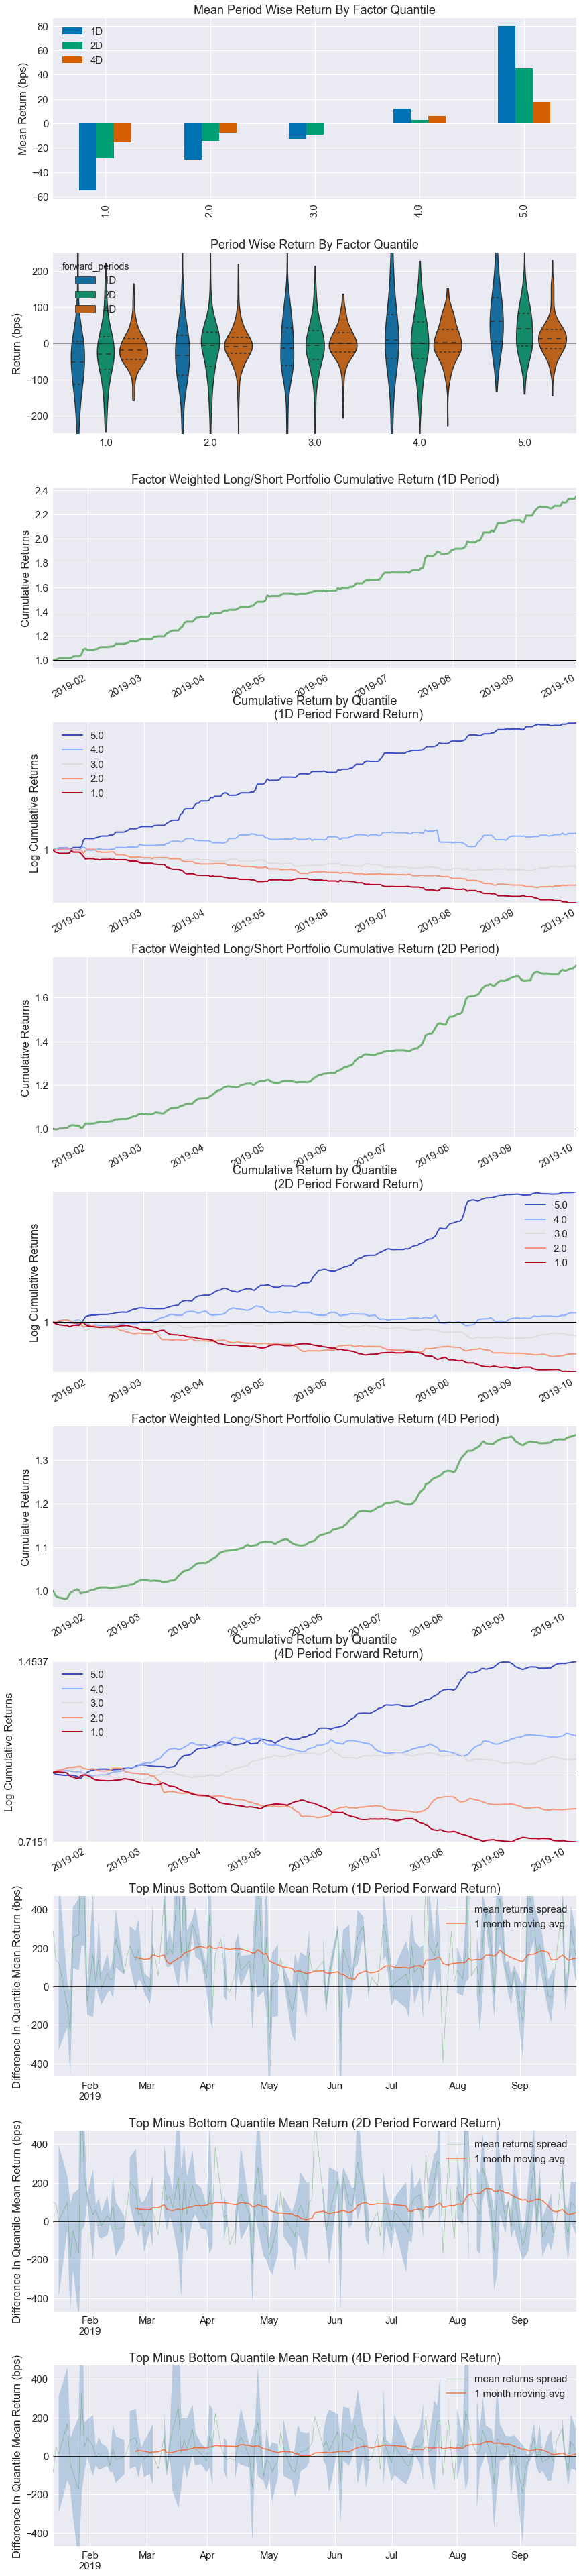

In [148]:
al.tears.create_returns_tear_sheet(factor_train, group_neutral=False, by_group=False)

Information Analysis


1D     2D     4D
IC Mean            0.344  0.215  0.148
IC Std.            0.344  0.403  0.398
Risk-Adjusted IC   1.001  0.534  0.372
t-stat(IC)        11.719  6.256  4.357
p-value(IC)        0.000  0.000  0.000
IC Skew           -0.634 -0.420 -0.272
IC Kurtosis       -0.081 -0.259 -0.616

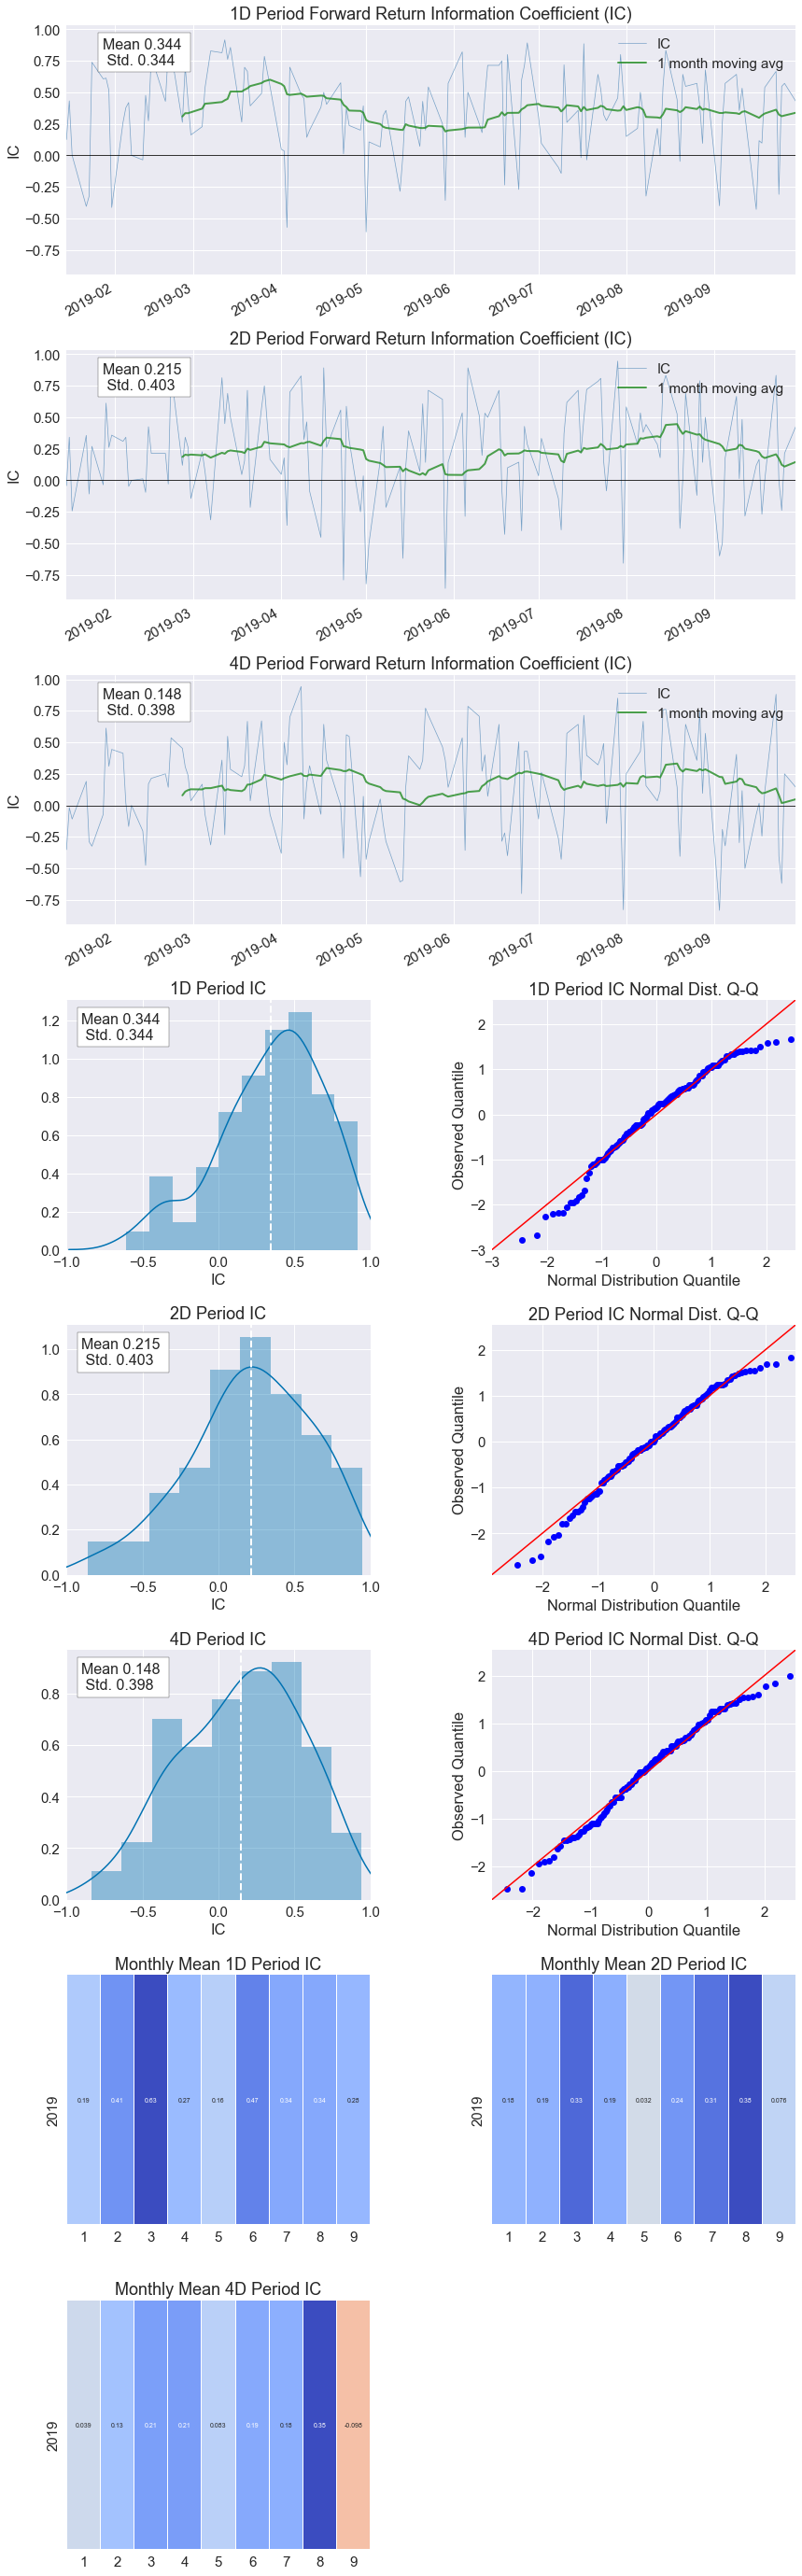

In [149]:
al.tears.create_information_tear_sheet(factor_train, by_group=False)

Turnover Analysis


1D     2D     4D
Quantile 1 Mean Turnover   0.782  0.714  0.776
Quantile 2 Mean Turnover   0.821  0.831  0.801
Quantile 3 Mean Turnover   0.784  0.782  0.771
Quantile 4 Mean Turnover   0.871  0.794  0.888
Quantile 5 Mean Turnover   0.809  0.809  0.783

1D    2D    4D
Mean Factor Rank Autocorrelation -0.003  0.04  0.02

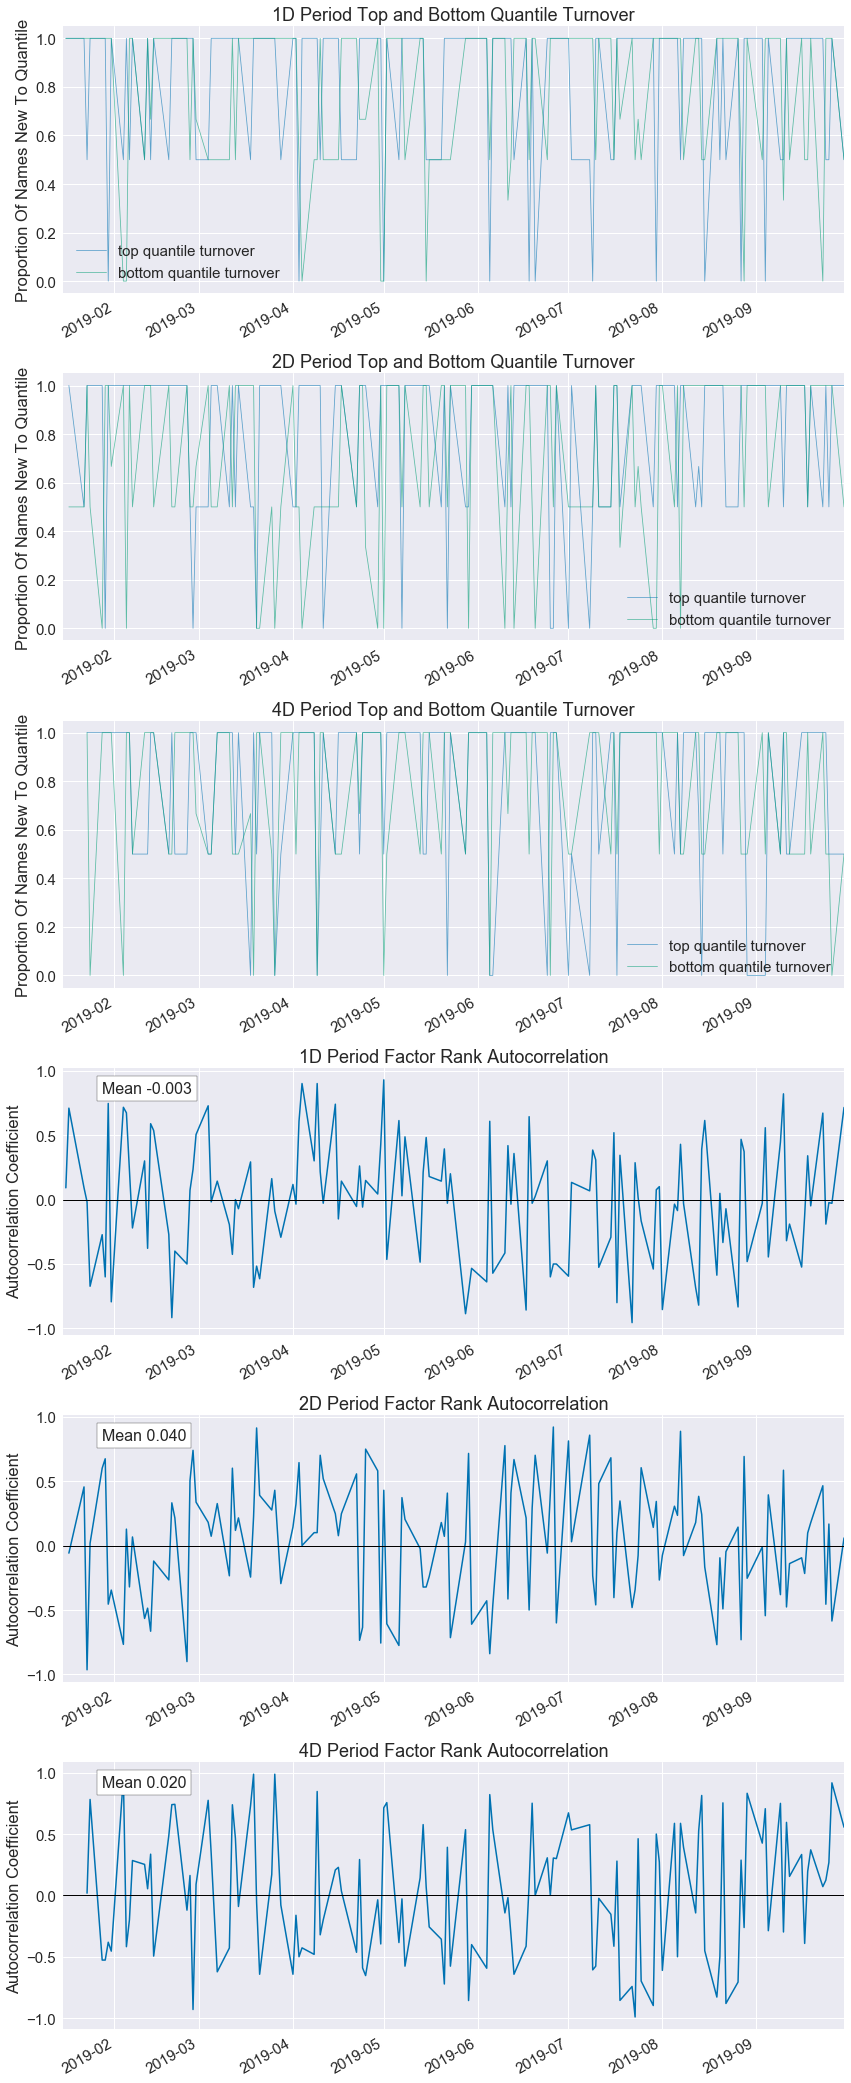

In [150]:
al.tears.create_turnover_tear_sheet(factor_train)

#### Test

In [151]:
factor_test=al.utils.get_clean_factor_and_forward_returns(SentimentTableTest.stack().dropna(),
                                                          price_test,
                                                          by_group=False,
                                                          quantiles=5,
                                                          periods=(1,2,3),
                                                          filter_zscore=20)

Dropped 20.1% entries from factor data: 20.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### factor value 从小到大排, 小的落入小号组, 大的落到大号组, 小号组是bottom, 大号组是top

Returns Analysis


1D     2D     3D
Ann. alpha                                     -0.129  0.078  0.212
beta                                           -0.123 -0.159 -0.190
Mean Period Wise Return Top Quantile (bps)      4.382  0.468  3.013
Mean Period Wise Return Bottom Quantile (bps)  11.343  7.964 -0.685
Mean Period Wise Spread (bps)                  -6.545 -5.745  6.177

/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:831: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


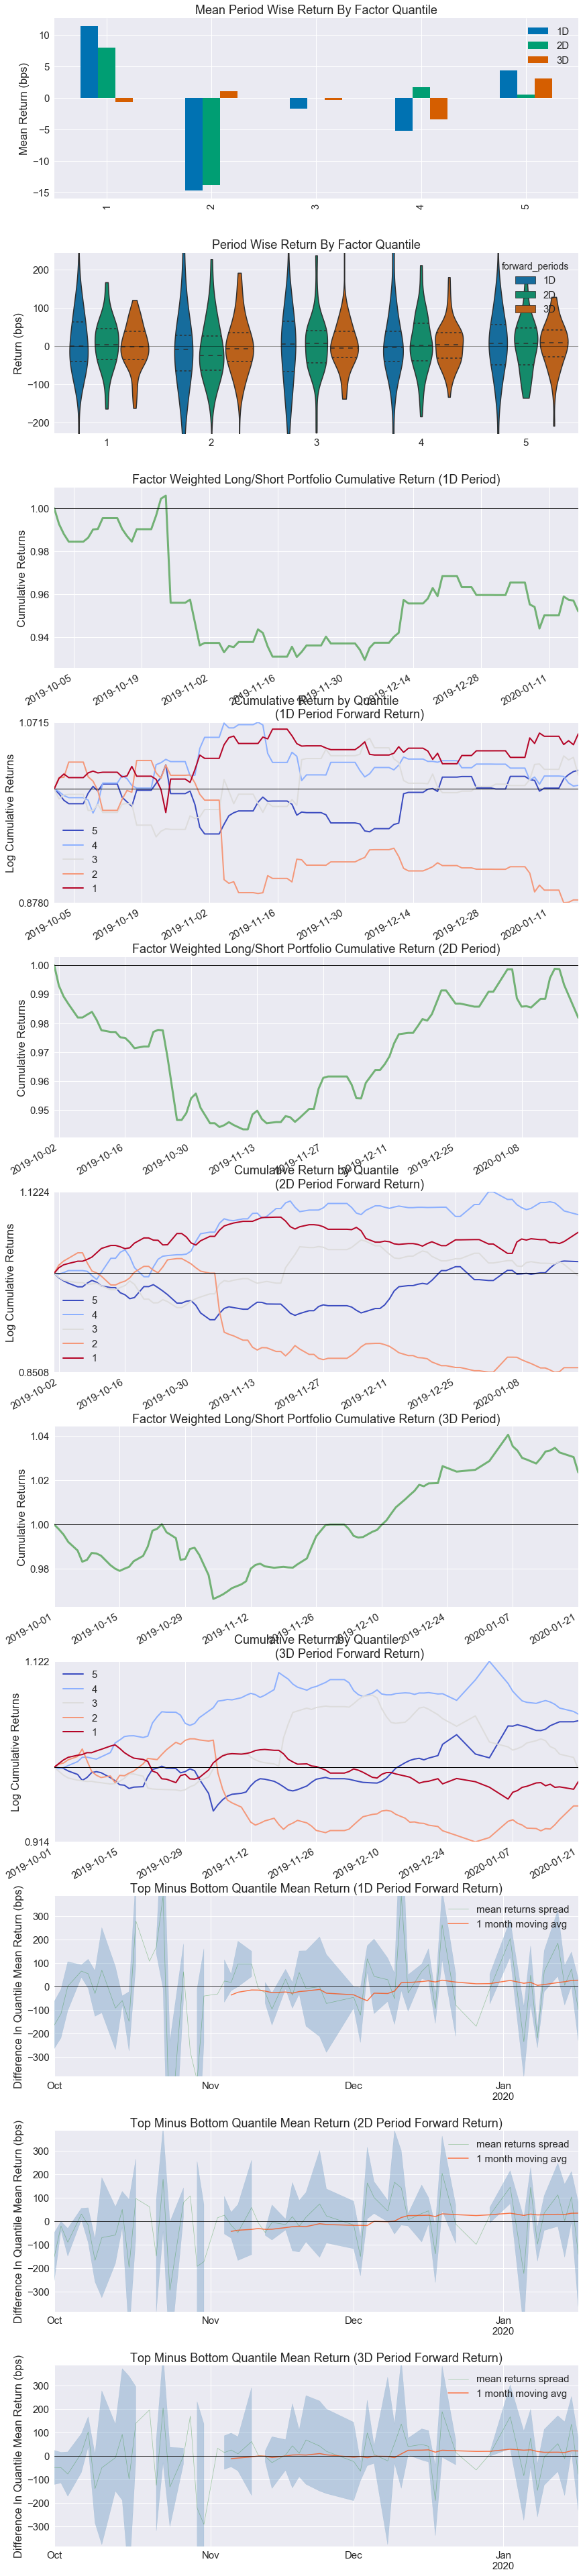

In [152]:
al.tears.create_returns_tear_sheet(factor_test, group_neutral=False, by_group=False)

Information Analysis


1D     2D     3D
IC Mean          -0.031  0.030  0.028
IC Std.           0.387  0.419  0.401
Risk-Adjusted IC -0.079  0.071  0.069
t-stat(IC)       -0.598  0.538  0.519
p-value(IC)       0.552  0.593  0.606
IC Skew          -0.136 -0.322 -0.166
IC Kurtosis      -0.665 -0.754 -0.610

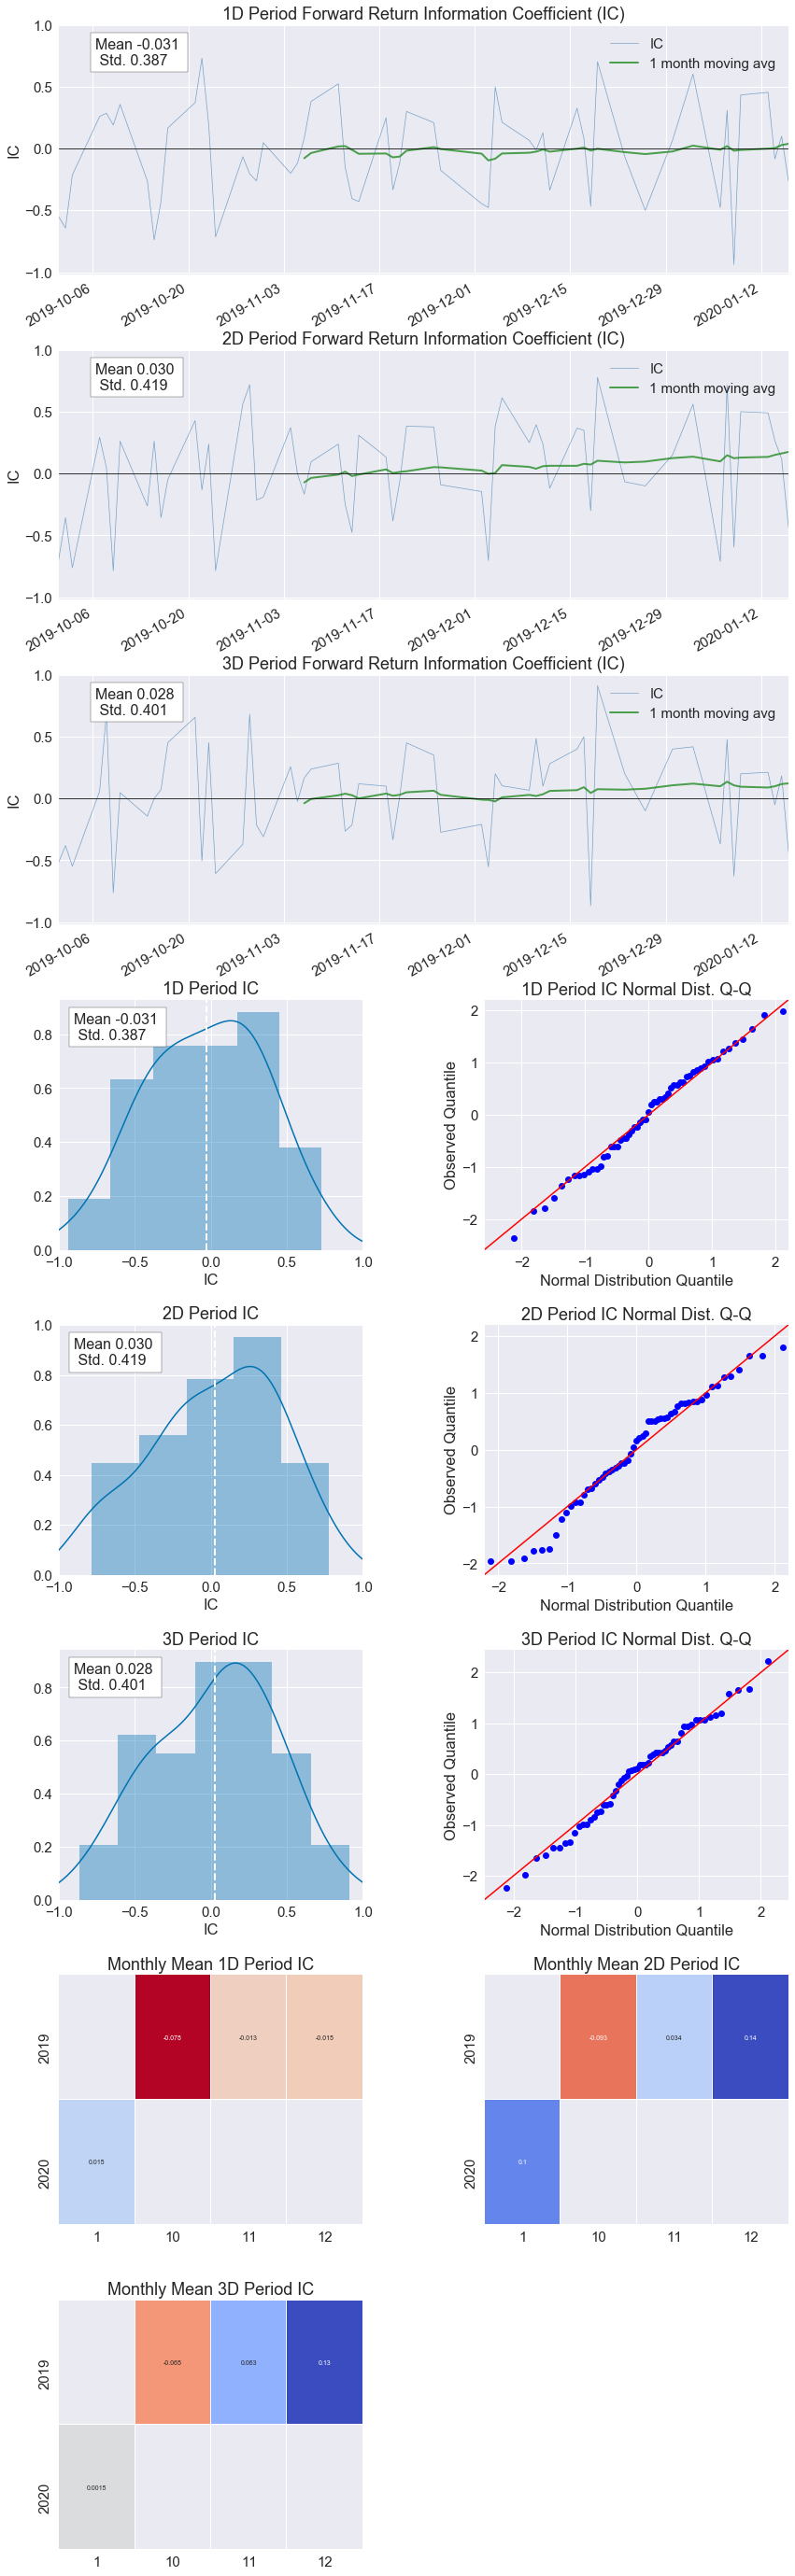

In [153]:
al.tears.create_information_tear_sheet(factor_test, by_group=False)

Turnover Analysis


1D     2D     3D
Quantile 1 Mean Turnover   0.759  0.767  0.731
Quantile 2 Mean Turnover   0.873  0.796  0.840
Quantile 3 Mean Turnover   0.812  0.827  0.778
Quantile 4 Mean Turnover   0.786  0.773  0.796
Quantile 5 Mean Turnover   0.786  0.727  0.815

1D     2D    3D
Mean Factor Rank Autocorrelation  0.007  0.079  0.07

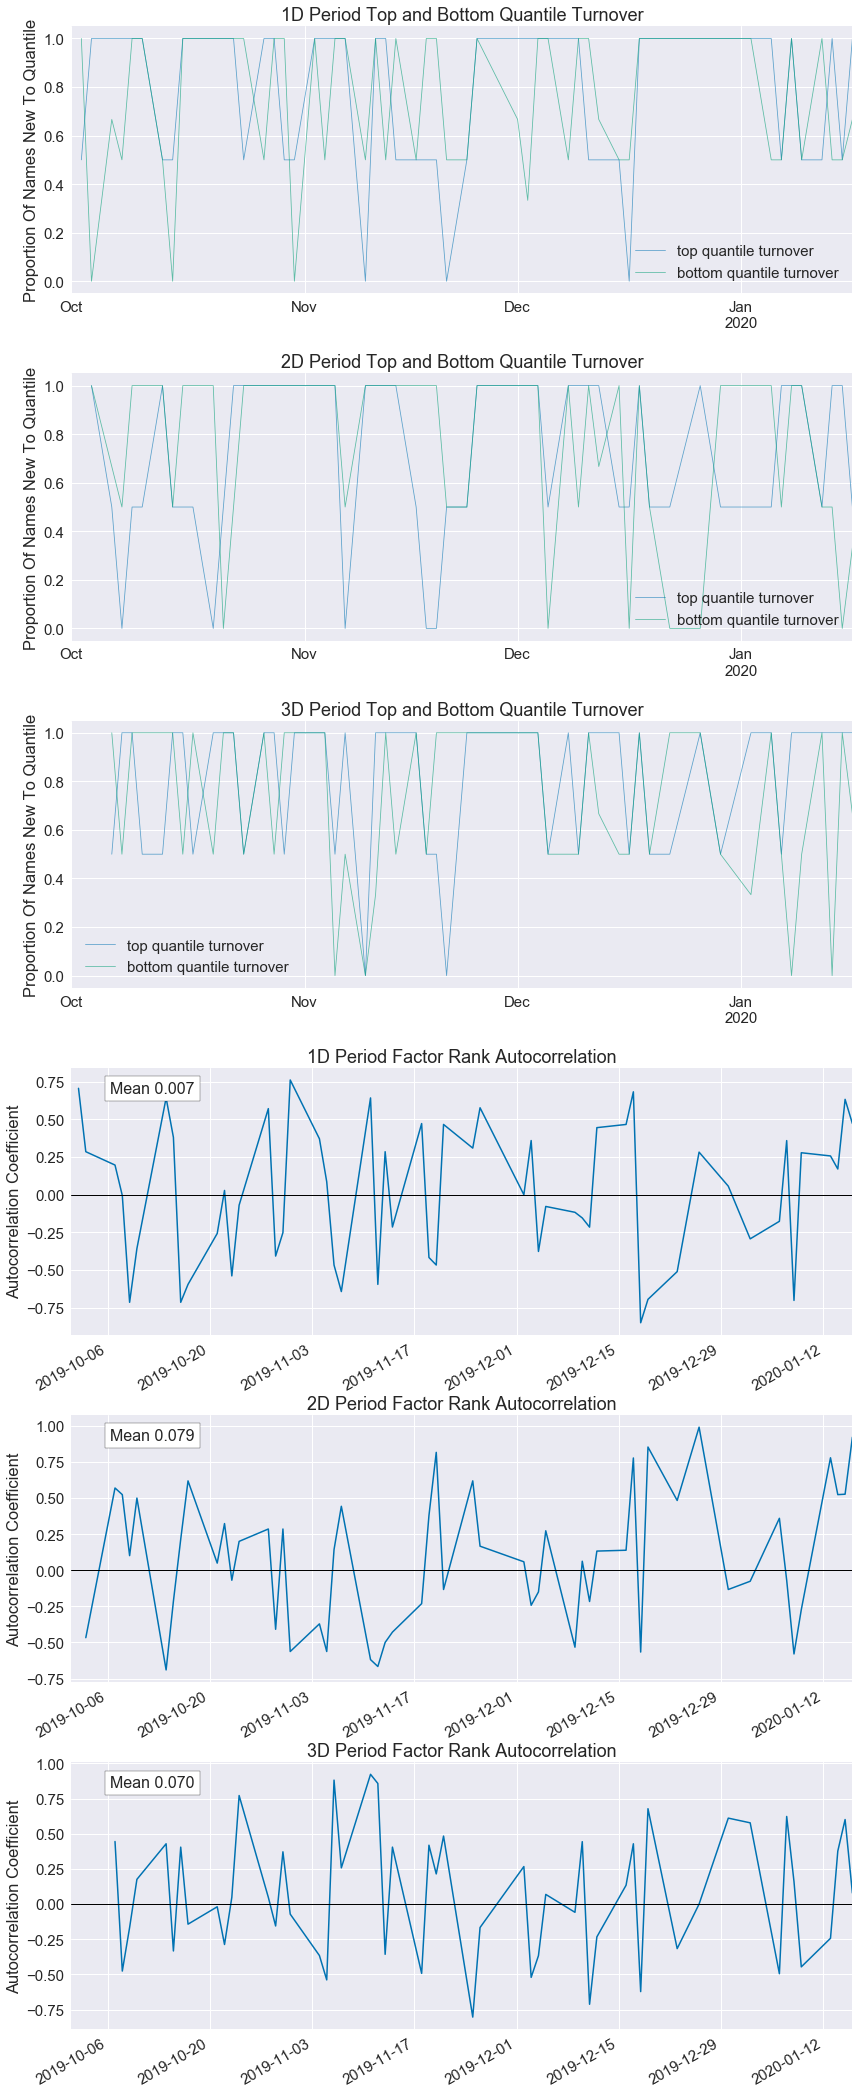

In [154]:
al.tears.create_turnover_tear_sheet(factor_test)